<header style="text-align: center; padding: 20px;">
  <h1 style="font-size: 2.5em; margin-bottom: 0.2em;">Financial Time Series Analysis</h1>
  <h2 style="font-weight: normal; font-size: 1.5em; color: #555;">Multivariate GARCH and Var Analysis</h2>
  <p style="font-size: 1.1em; color: #888;">Project | Time Series Analysis | Spring 2025</p>
  <hr style="margin-top: 20px; border: none; border-top: 1px solid #ccc;">
</header>


# Explanatory Data Analysis - **EDA**

In [1]:
#! pip install -q investpy
#! pip install -q requests-cache
#! pip install -q yfinance
#! pip install --upgrade matplotlib
#! pip install matplotlib
! pip install pandas-datareader


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf  # equivalent to quantmod
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.nonparametric.smoothers_lowess import lowess
from arch import arch_model  
from scipy import stats
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import warnings
from curl_cffi import requests

import requests_cache
import investpy
import pickle
import os

# Display settings
# plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from data_engineering import DataDownloader 
downloader = DataDownloader() #create isance of the class in our main method


import matplotlib.cbook as cbook
import matplotlib.dates as mdates

from statsmodels.stats.stattools import jarque_bera
from scipy.stats import norm
import statsmodels.api as sm

## Data Alignment and Missing Value Handling

In this section, we addressed a key issue in working with a portfolio composed of heterogeneous financial instruments: **differences in trading calendars**. Specifically, our portfolio includes:

- Equities (Boeing, traded on NYSE)
- Equity Index (S&P 500)
- Commodity (Gold)
- Currency (USD/PLN)
- Cryptocurrency (Ethereum)

### Problem

Some of these assets (like Ethereum) are traded **7 days a week**, while others (like Boeing and SP500) follow **standard business calendars**, excluding weekends and public holidays. This discrepancy leads to **asynchronous time series** and a misalignment of data points, which can significantly impact:

- Log-returns computation
- Portfolio aggregation
- Volatility modeling (especially GARCH models)
- Value-at-Risk estimation

### Our Approach

To ensure consistency across all time series:

1. **All assets were reindexed to business days (`freq='B'`)** to create a uniform temporal structure based on a 5-day trading week.
2. We identified the asset with the **highest number of missing values** after reindexing.
3. We used that asset’s index as the **reference calendar** for all other series.
4. We applied **forward fill (`ffill`)** to propagate last valid observations and eliminate remaining NaN values.

This guarantees:
- Fully aligned data across all assets
- Absence of NaNs in both training (2020-05-01 to 2024-04-30) and test (2024-05-01 to 2025-04-30) periods

### Alternatives Considered (But Not Used)

- **Mixed-Frequency Handling (e.g., MIDAS, Asynchronous GARCH)**: These methods are more complex, require advanced econometric models, and are less suitable for the rolling window VaR analysis required in this project.
- **Interpolation over weekends**: Discarded to avoid introducing artificial returns and distortions in volatility dynamics.

### Justification

While forward filling may mask some weekend moves (especially for crypto), the **impact is negligible**:
- Crypto contributes **only 20%** to the equally weighted portfolio.
- Business-day filtering leads to **only minor information loss**.
- Ensures a cleaner, synchronous dataset suitable for standard econometric modeling.


By taking this approach, we ensured that all subsequent analyses—return computation, portfolio construction, GARCH estimation, and Value-at-Risk simulation—are built on a clean and consistent foundation.


In [2]:
tickers = ['^GSPC', 'BA', 'ETH-USD', 'PLN=X', 'GC=F']
data_dict = downloader.load_or_download_data(tickers, start='2020-05-01', end='2025-05-01') #call external class to download

## NB: questi sono i dataset con TUTTE LE DATE!! --> vanno splittati in In-sample (train) e oos (test)
gspc_full = data_dict.get('gspc')
ba_full = data_dict.get('ba')
eth_full = data_dict.get('ethusd')
usdpln_full = data_dict.get('plnx')
gold_full = data_dict.get('gcf')

#Test set
# Data di split
split_date = '2024-05-01'

# Funzione per splittare un dataframe
def split_train_test(df, split_date):
    train = df[df.index < split_date]
    test = df[df.index >= split_date]
    return train, test

# Splitting
gspc_train, gspc_test = split_train_test(gspc_full, split_date)
ba_train, ba_test = split_train_test(ba_full, split_date)
eth_train, eth_test = split_train_test(eth_full, split_date)
usdpln_train, usdpln_test = split_train_test(usdpln_full, split_date)
gold_train, gold_test = split_train_test(gold_full, split_date)

# Controllo rapido
for name, df_train, df_test in [
    ("GSPC", gspc_train, gspc_test),
    ("BA", ba_train, ba_test),
    ("ETH-USD", eth_train, eth_test),
    ("USD/PLN", usdpln_train, usdpln_test),
    ("Gold", gold_train, gold_test)
]:
    print(f"{name} — Train: {df_train.shape}, Test: {df_test.shape}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


✅ Data downloaded and saved successfully.
GSPC — Train: (1461, 5), Test: (365, 5)
BA — Train: (1461, 5), Test: (365, 5)
ETH-USD — Train: (1461, 5), Test: (365, 5)
USD/PLN — Train: (1461, 5), Test: (365, 5)
Gold — Train: (1461, 5), Test: (365, 5)


In [3]:
# Copia originale dei DataFrame
train_dfs = {
    "GSPC": gspc_train.copy(),
    "BA": ba_train.copy(),
    "ETH-USD": eth_train.copy(),
    "USD/PLN": usdpln_train.copy(),
    "Gold": gold_train.copy()
}

test_dfs = {
    "GSPC": gspc_test.copy(),
    "BA": ba_test.copy(),
    "ETH-USD": eth_test.copy(),
    "USD/PLN": usdpln_test.copy(),
    "Gold": gold_test.copy()
}

def align_dataframes_consistently(dfs):
    original_shapes = {name: df.shape for name, df in dfs.items()}
    previous_len = None
    while True:
        common_index = sorted(set.intersection(*(set(df.index) for df in dfs.values())))
        for key in dfs:
            dfs[key] = dfs[key].reindex(common_index).dropna()
        current_len = len(set.intersection(*(set(df.index) for df in dfs.values())))
        if current_len == previous_len:
            break
        previous_len = current_len
    final_shapes = {name: df.shape for name, df in dfs.items()}
    return dfs, original_shapes, final_shapes

# Allinea train set
print("=== CHANGES TO TRAIN SETS (stable iteration) ===")
train_dfs_aligned, train_original_shapes, train_final_shapes = align_dataframes_consistently(train_dfs)
for name in train_dfs:
    print(f"{name} — Before: {train_original_shapes[name]}, After: {train_final_shapes[name]}")
    if name == "GSPC":
        gspc_train = train_dfs_aligned[name]
    elif name == "BA":
        ba_train = train_dfs_aligned[name]
    elif name == "ETH-USD":
        eth_train = train_dfs_aligned[name]
    elif name == "USD/PLN":
        usdpln_train = train_dfs_aligned[name]
    elif name == "Gold":
        gold_train = train_dfs_aligned[name]

# Allinea test set
print("\n=== CHANGES TO TEST SETS (stable iteration) ===")
test_dfs_aligned, test_original_shapes, test_final_shapes = align_dataframes_consistently(test_dfs)
for name in test_dfs:
    print(f"{name} — Before: {test_original_shapes[name]}, After: {test_final_shapes[name]}")
    if name == "GSPC":
        gspc_test = test_dfs_aligned[name]
    elif name == "BA":
        ba_test = test_dfs_aligned[name]
    elif name == "ETH-USD":
        eth_test = test_dfs_aligned[name]
    elif name == "USD/PLN":
        usdpln_test = test_dfs_aligned[name]
    elif name == "Gold":
        gold_test = test_dfs_aligned[name]


=== CHANGES TO TRAIN SETS (stable iteration) ===
GSPC — Before: (1461, 5), After: (1006, 5)
BA — Before: (1461, 5), After: (1006, 5)
ETH-USD — Before: (1461, 5), After: (1006, 5)
USD/PLN — Before: (1461, 5), After: (1006, 5)
Gold — Before: (1461, 5), After: (1006, 5)

=== CHANGES TO TEST SETS (stable iteration) ===
GSPC — Before: (365, 5), After: (249, 5)
BA — Before: (365, 5), After: (249, 5)
ETH-USD — Before: (365, 5), After: (249, 5)
USD/PLN — Before: (365, 5), After: (249, 5)
Gold — Before: (365, 5), After: (249, 5)


### Technical Considerations – Data Alignment

One of the main issues in working with financial time series is the **difference in trading calendars** between asset classes:

- **FX, cryptocurrencies, and commodities** are traded **continuously**, including weekends and many public holidays.
- **Stocks and ETFs**, however, follow the **U.S. NYSE trading calendar**, which consists of:
  - **5 trading days per week** (Monday to Friday)
  - **Exclusion of U.S. market holidays**


### Alignment Strategy

To ensure consistency across all datasets, we adopt the **Stock Exchange calendar (NYSE)** as our reference. This means:

- We reindex all continuous trading instruments (such as FX or crypto) to match the **stock market trading days**.
- Trading data available on weekends or holidays for these continuous assets is treated as **after-hours activity** and is **excluded** from our analysis.

This approach ensures all datasets share a **common and aligned time index**, making them suitable for comparison, modeling, and joint analysis.


### 📌 Note: Naming Convention for Train/Test DataFrames

For each financial asset, the dataset has been split into two subsets:

- **Train set**: includes data before the split date (`2024-05-01`).
- **Test set**: includes data from `2024-05-01` onward.

The DataFrames follow this naming convention:

| Asset          | Train DataFrame     | Test DataFrame      |
|----------------|---------------------|----------------------|
| S&P 500        | `gspc_train`        | `gspc_test`          |
| Boeing         | `ba_train`          | `ba_test`            |
| Ethereum (ETH) | `eth_train`         | `eth_test`           |
| USD/PLN        | `usdpln_train`      | `usdpln_test`        |
| Gold           | `gold_train`        | `gold_test`          |

All datasets have been **aligned to a common calendar** and **cleaned of NaN values** after the split.


### 📌 Why Use In-Sample and Out-of-Sample Periods?

Splitting the data into **in-sample** and **out-of-sample** periods is essential for model development and evaluation:

- **In-Sample**: Used for estimating and fitting models. This is where parameters are learned and diagnostics are performed.
- **Out-of-Sample**: Used for testing the predictive performance of the model on unseen data, providing an unbiased assessment of its accuracy.

This approach helps prevent overfitting and ensures that the model generalizes well to future data, especially when calculating Value-at-Risk (VaR) using a rolling window.


# Closing prices displaying - In Sample

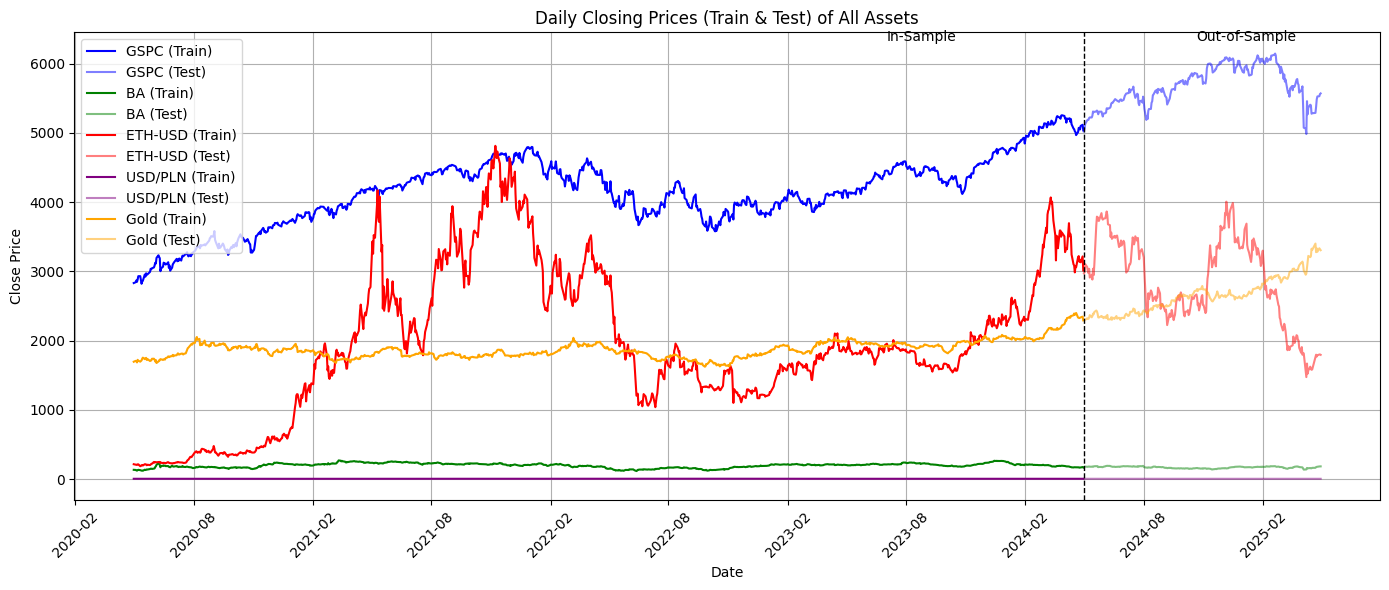

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Define color palette
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan']

# Mapping asset names to their in-sample and out-of-sample DataFrames
asset_data = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USD/PLN': (usdpln_train, usdpln_test),
    'Gold': (gold_train, gold_test)
}

# Split date for reference line
split_date = pd.to_datetime("2024-05-01")

# Start the plot
plt.figure(figsize=(14, 6))

# Plot each asset's in-sample and out-of-sample closing prices
for i, (name, (df_train, df_test)) in enumerate(asset_data.items()):
    color = colors[i % len(colors)]
    
    if 'Close' in df_train.columns and 'Close' in df_test.columns:
        # In-sample
        plt.plot(df_train.index, df_train['Close'], label=f'{name} (Train)', color=color)
        # Out-of-sample
        plt.plot(df_test.index, df_test['Close'], label=f'{name} (Test)', color=color, alpha=0.5)

# Vertical line at split date
plt.axvline(x=split_date, color='black', linestyle='--', linewidth=1)

# Annotate In-Sample and Out-of-Sample
ymin, ymax = plt.ylim()
xmid = plt.xlim()
plt.text(x=split_date - pd.Timedelta(days=250), y=ymax * 0.98, s="In-Sample", ha='center', fontsize=10, color='black')
plt.text(x=split_date + pd.Timedelta(days=250), y=ymax * 0.98, s="Out-of-Sample", ha='center', fontsize=10, color='black')

# Format axes
plt.title('Daily Closing Prices (Train & Test) of All Assets')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In order to appreciate the changing on PLN/USD asset we need to plot it alone instahed of rescale

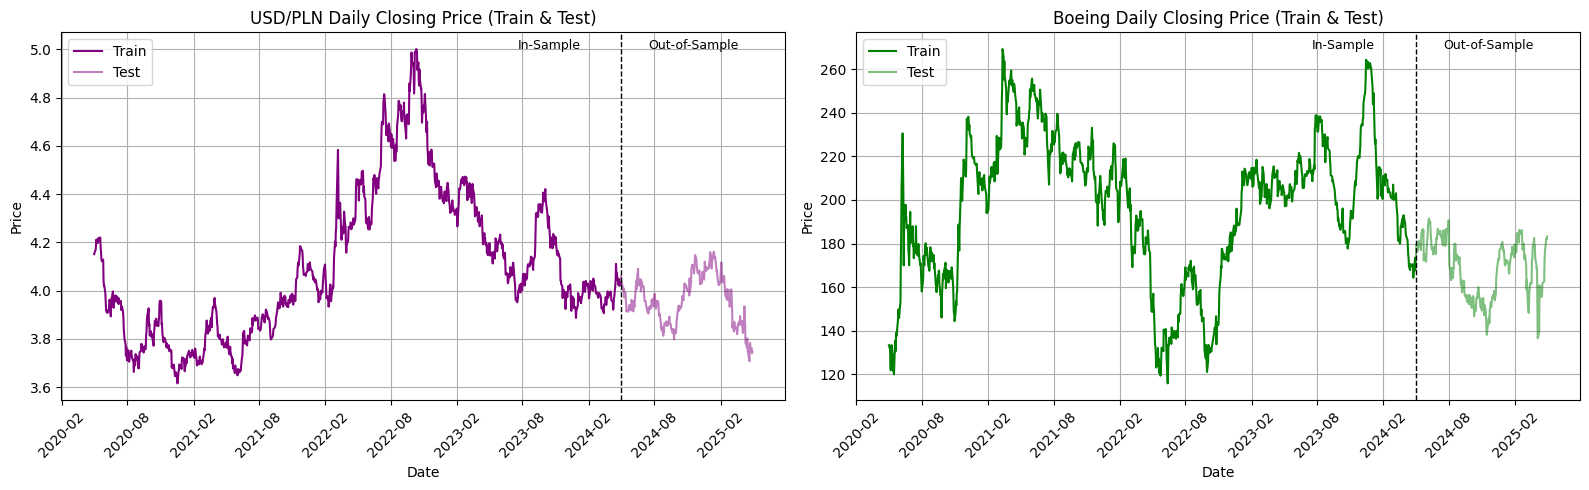

In [5]:
# In-sample and out-of-sample data
usdpln_train_df = usdpln_train.copy()
usdpln_test_df = usdpln_test.copy()
boeing_train_df = ba_train.copy()
boeing_test_df = ba_test.copy()

# Date of split
split_date = pd.to_datetime("2024-05-01")

if 'Close' in usdpln_train_df.columns and 'Close' in boeing_train_df.columns:

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

    # --- USD/PLN ---
    axes[0].plot(usdpln_train_df.index, usdpln_train_df['Close'], color='purple', label='Train')
    axes[0].plot(usdpln_test_df.index, usdpln_test_df['Close'], color='purple', alpha=0.5, label='Test')
    axes[0].axvline(x=split_date, color='black', linestyle='--', linewidth=1)
    axes[0].text(split_date - pd.Timedelta(days=200), usdpln_train_df['Close'].max(), 'In-Sample',
                 ha='center', fontsize=9)
    axes[0].text(split_date + pd.Timedelta(days=200), usdpln_train_df['Close'].max(), 'Out-of-Sample',
                 ha='center', fontsize=9)
    axes[0].set_title("USD/PLN Daily Closing Price (Train & Test)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Price")
    axes[0].grid(True)
    axes[0].legend()
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[0].tick_params(axis='x', rotation=45)

    # --- Boeing ---
    axes[1].plot(boeing_train_df.index, boeing_train_df['Close'], color='green', label='Train')
    axes[1].plot(boeing_test_df.index, boeing_test_df['Close'], color='green', alpha=0.5, label='Test')
    axes[1].axvline(x=split_date, color='black', linestyle='--', linewidth=1)
    axes[1].text(split_date - pd.Timedelta(days=200), boeing_train_df['Close'].max(), 'In-Sample',
                 ha='center', fontsize=9)
    axes[1].text(split_date + pd.Timedelta(days=200), boeing_train_df['Close'].max(), 'Out-of-Sample',
                 ha='center', fontsize=9)
    axes[1].set_title("Boeing Daily Closing Price (Train & Test)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Price")
    axes[1].grid(True)
    axes[1].legend()
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print("USD/PLN or Boeing data not found or missing 'Close' column.")


---
# **Investigating returns**
## 1. Single indeces

### 1.1 Log Returns

From this point onward, we will use log-returns (i.e., the natural logarithm of price relatives) as our primary measure of asset returns throughout the analysis.
Log-returns are widely preferred in finance and econometrics for several reasons — to name just a few:

1. Time Additivity: Log-returns can be summed over time intervals, making them suitable for cumulative return calculations and for time series modeling.

2. Suitability for Volatility Modelling: GARCH-type models and other conditional volatility frameworks are typically applied to log-returns, as they often exhibit clearer volatility clustering and more regular statistical properties (as will become evident later in the analysis).

As a note, we calculate the log-returns using the closing price for the days t and t-1, so that we get the so said log-return 'close to close'. The choice of close-to-close log returns is not arbitrary but is motivated by their ability to incorporate both intra-day and overnight price dynamics.
Unlike returns computed over specific intraday intervals, close-to-close returns capture the full effect of market activity, including periods when the market is officially closed but price-relevant information is still being absorbed — such as after-hours news, earnings releases, or macroeconomic announcements.

This means that close-to-close returns embed a component of overnight volatility, which is particularly relevant for modeling total risk and for estimating volatility using GARCH-type models. Ignoring this component would lead to an underestimation of true return variability, especially in assets or markets that are sensitive to after-hours information flows.

We begin by plotting the daily log-returns for each of the five components: a stock (Boeing), a stock index (S&P 500), a cryptocurrency (Ethereum), a commodity (Gold), and a foreign exchange rate (USD/PLN).
These plots provide a preliminary visual inspection of the return behavior of each asset, highlighting possible volatility patterns, jumps, or outliers. In particular, we aim to identify early signs of heteroscedasticity and volatility clustering, which are key motivations for the use of GARCH-type models later in the analysis.

$$
r_{t}=\ln({\frac{P_t}{P_{t-1}}})
$$


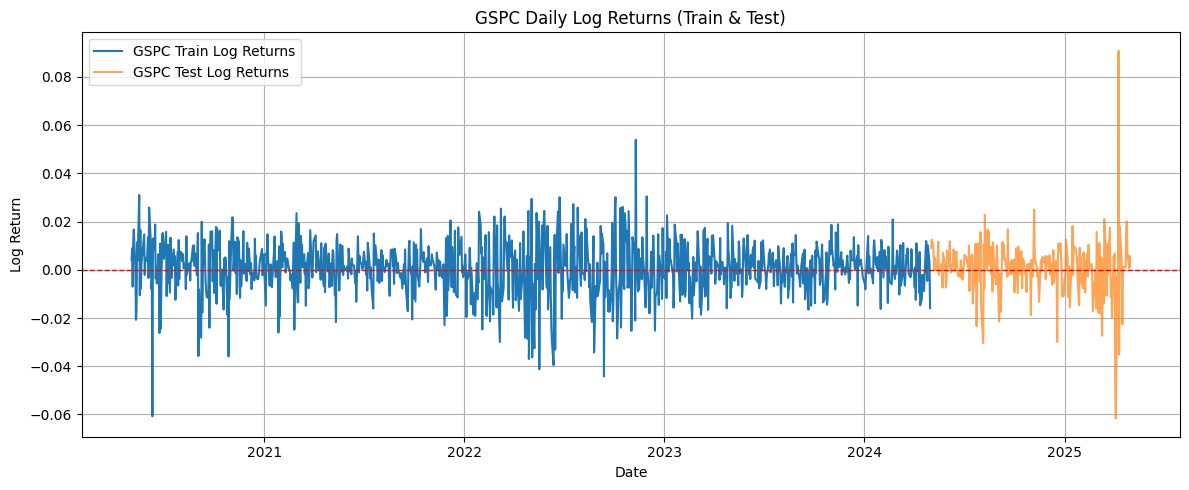

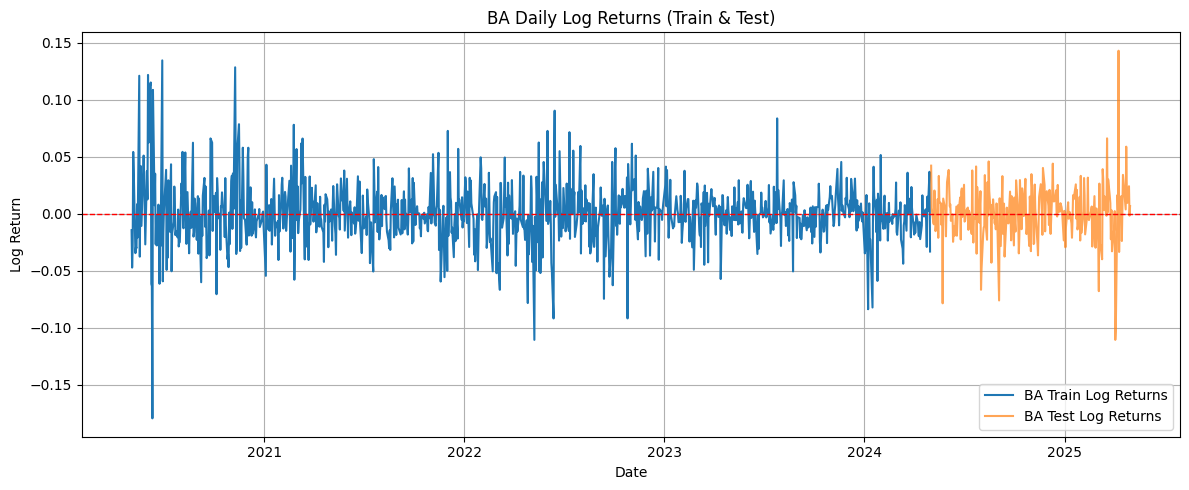

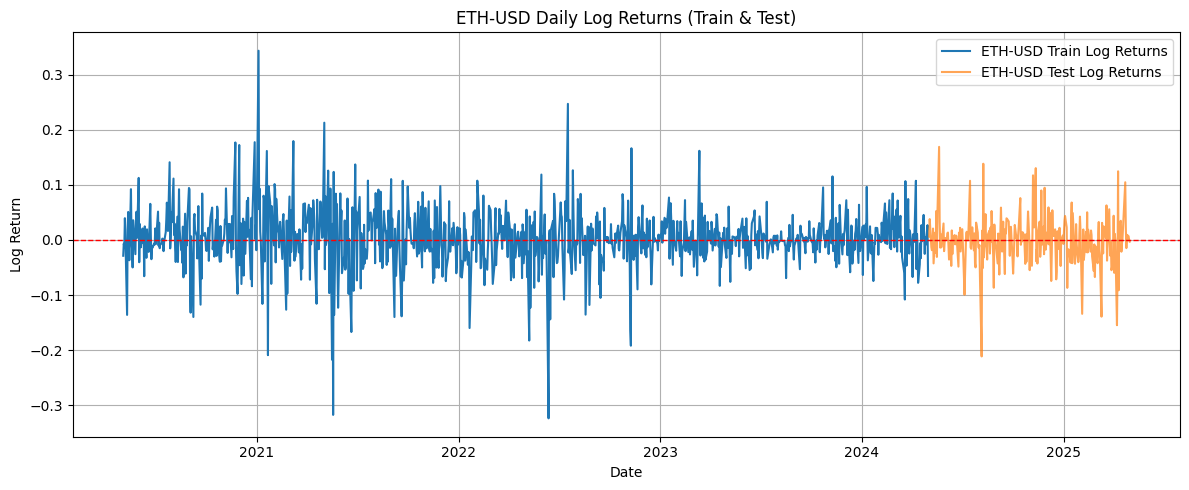

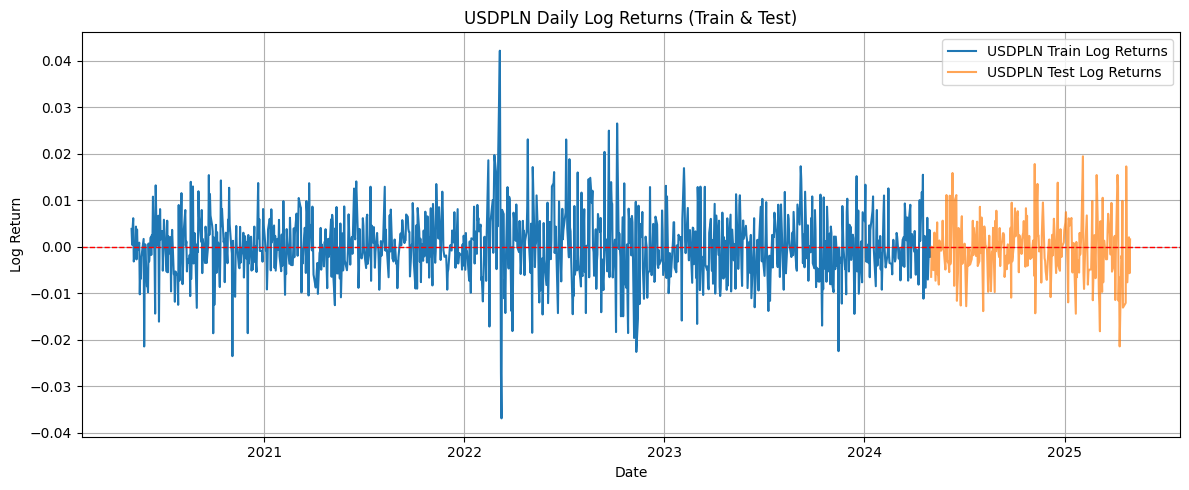

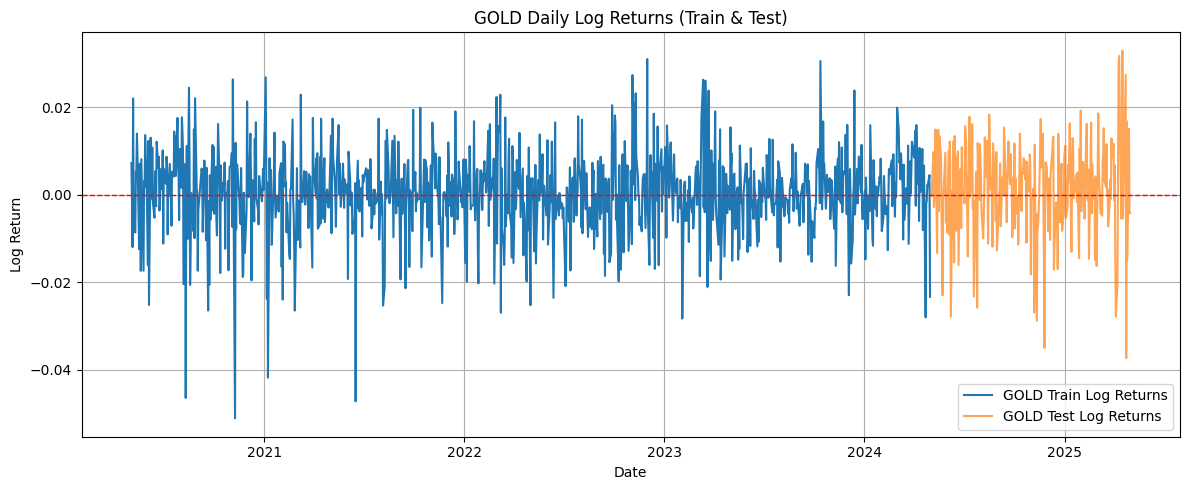

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Dizionario per salvare i log-return
log_return_dict = {}

# Lista degli asset e dei rispettivi DataFrame train/test
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

for name, (df_train, df_test) in assets.items():
    # Calcola log-return per il train set
    train = df_train.copy()
    train['log_return'] = np.log(train['Close']).diff()
    log_return_dict[f'{name}_train_logReturn'] = train[['log_return']].dropna()

    # Calcola log-return per il test set
    test = df_test.copy()
    test['log_return'] = np.log(test['Close']).diff()
    log_return_dict[f'{name}_test_logReturn'] = test[['log_return']].dropna()

    # Plot (opzionale)
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['log_return'], label=f'{name} Train Log Returns')
    plt.plot(test.index, test['log_return'], label=f'{name} Test Log Returns', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'{name} Daily Log Returns (Train & Test)')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
for name, df in log_return_dict.items():
    print(f'>>> {name}.head()')
    print(df.head())
    print('\n' + '-'*50 + '\n')


>>> GSPC_train_logReturn.head()
Price       log_return
Date                  
2020-05-04     0.00424
2020-05-05     0.00900
2020-05-06    -0.00700
2020-05-07     0.01144
2020-05-08     0.01673

--------------------------------------------------

>>> GSPC_test_logReturn.head()
Price       log_return
Date                  
2024-05-02     0.00909
2024-05-03     0.01248
2024-05-06     0.01027
2024-05-07     0.00134
2024-05-08    -0.00001

--------------------------------------------------

>>> BA_train_logReturn.head()
Price       log_return
Date                  
2020-05-04    -0.01442
2020-05-05    -0.04719
2020-05-06    -0.02864
2020-05-07     0.05422
2020-05-08     0.03656

--------------------------------------------------

>>> BA_test_logReturn.head()
Price       log_return
Date                  
2024-05-02     0.04220
2024-05-03     0.00524
2024-05-06    -0.00804
2024-05-07    -0.00924
2024-05-08     0.02039

--------------------------------------------------

>>> ETH-USD_train_logR

### 1.2 Squared Log Returns

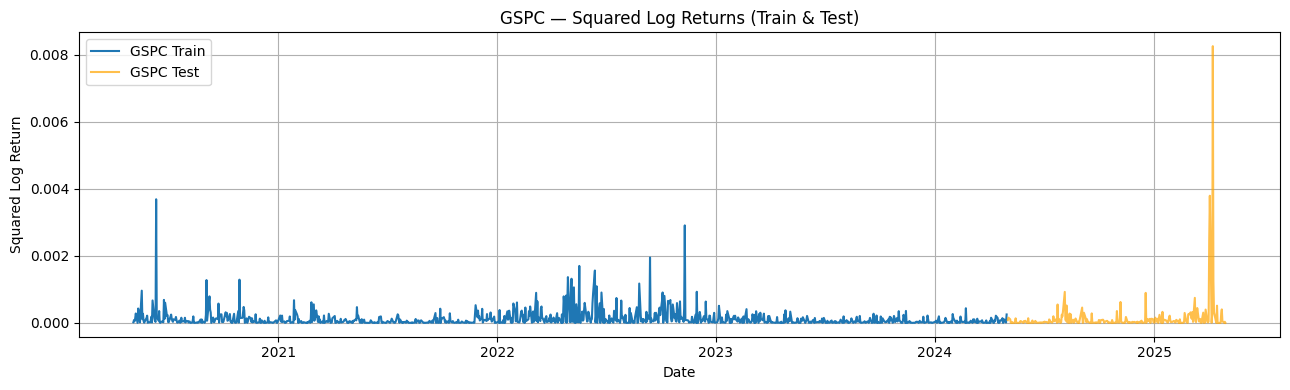

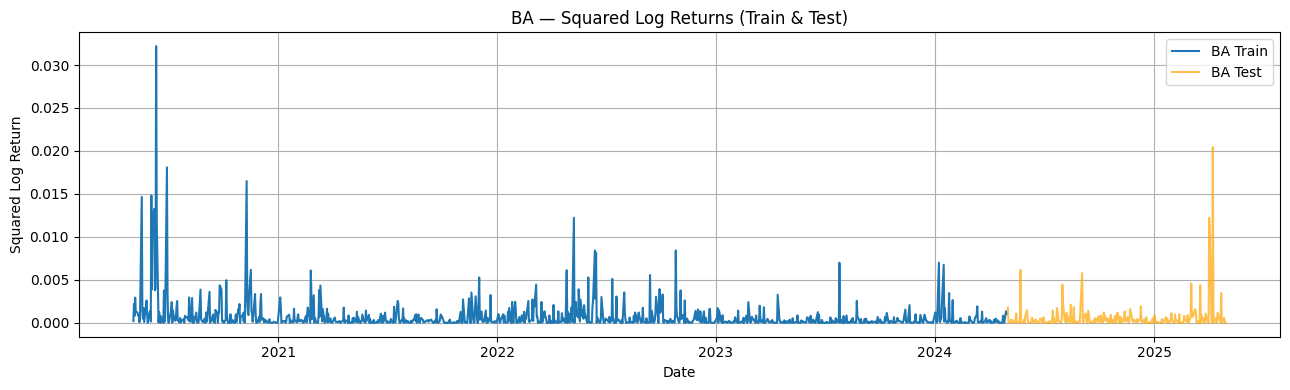

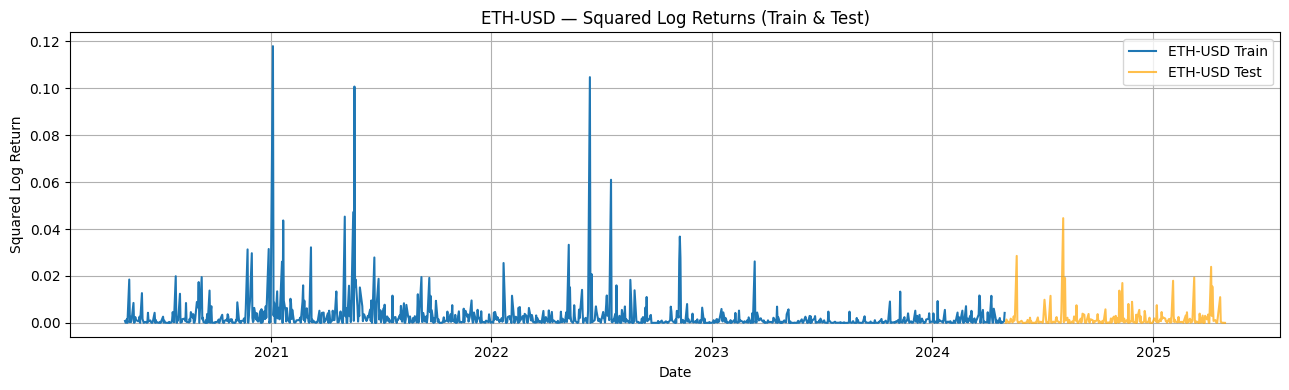

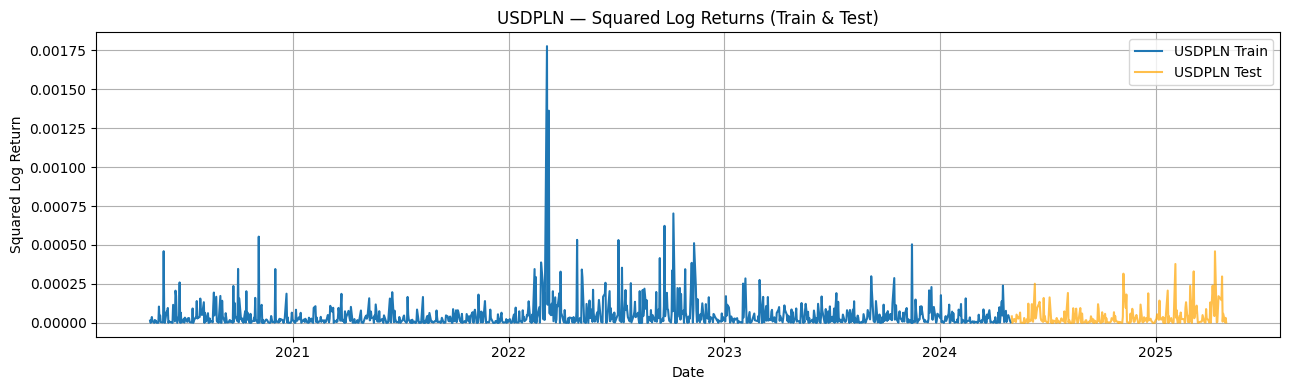

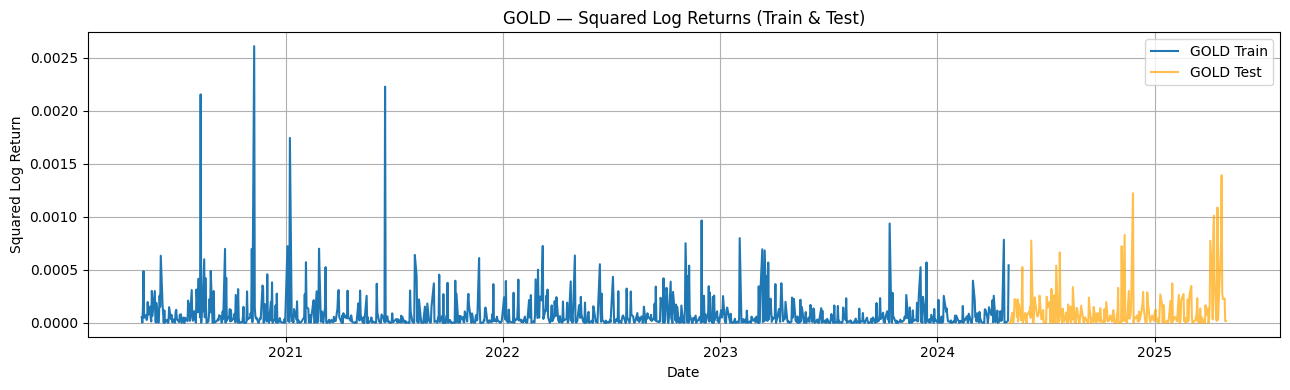

In [9]:
# Mapping of train/test DataFrames for each asset
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

# Compute and plot squared log-returns for each period (train and test)
for name, (df_train, df_test) in assets.items():
    # In-sample period
    train = df_train.copy()
    train['log_return'] = np.log(train['Close']).diff()
    train['squared_log_return'] = train['log_return'] ** 2

    # Out-of-sample period
    test = df_test.copy()
    test['log_return'] = np.log(test['Close']).diff()
    test['squared_log_return'] = test['log_return'] ** 2

    # Plot squared log-returns for both periods
    plt.figure(figsize=(13, 4))
    plt.plot(train.index, train['squared_log_return'], label=f'{name} Train')
    plt.plot(test.index, test['squared_log_return'], label=f'{name} Test', color='orange', alpha=0.7)
    plt.title(f'{name} — Squared Log Returns (Train & Test)')
    plt.xlabel('Date')
    plt.ylabel('Squared Log Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## 2. **Equally Weighted Portfolio**
### 2.1 Daily Log Returns 

The time series plots of daily log returns for all five assetes reveal a common and important empirical feature: heteroskedasticity, that is, the variance of returns varies over time. This is visually apparent through alternating periods of high volatility (large swings in returns) and low volatility (smaller, more stable fluctuations). Visual inspection provides valuable intuition, but it must be complemented with rigorous statistical tests to confirm the existence of ARCH effects (Autoregressive Conditional Heteroskedasticity), which are the foundation for GARCH-type models.

The next step involves computing the log return of the portfolio, defined as an equally weighted average of the five individual asset returns analyzed above. A fixed weight of 20% is assigned to each asset, representing a balanced allocation that gives equal importance to all components in the portfolio. As a consequence, we assume the portfolio is daily rebalanced to preserve these fixed weights over time. Under this assumption, the log-return of the portfolio can be computed as the weighted sum of the individual asset log-returns:
$$
r_{p,t} = \sum_{i=1}^{5} w_i \cdot r_{i,t}
$$

In [10]:
# Step 1: Create lists for in-sample and out-of-sample log returns
log_returns_train = []
log_returns_test = []

# Asset mapping
assets = {
    'GSPC': (gspc_train, gspc_test),
    'BA': (ba_train, ba_test),
    'ETH-USD': (eth_train, eth_test),
    'USDPLN': (usdpln_train, usdpln_test),
    'GOLD': (gold_train, gold_test)
}

# Step 2: Compute log returns and collect aligned series
for name, (df_train, df_test) in assets.items():
    # In-sample
    df_train = df_train.copy()
    df_train['log_return'] = np.log(df_train['Close']).diff()
    train_series = df_train[['log_return']].rename(columns={'log_return': name})
    log_returns_train.append(train_series)

    # Out-of-sample
    df_test = df_test.copy()
    df_test['log_return'] = np.log(df_test['Close']).diff()
    test_series = df_test[['log_return']].rename(columns={'log_return': name})
    log_returns_test.append(test_series)

# Step 3: Concatenate and align by date
log_return_train_df = pd.concat(log_returns_train, axis=1).dropna()
log_return_test_df = pd.concat(log_returns_test, axis=1).dropna()

# Step 4: Calculate equally weighted portfolio log returns
n_assets = log_return_train_df.shape[1]
log_return_train_df['portfolio'] = log_return_train_df.dot(np.repeat(1/n_assets, n_assets))

n_assets_test = log_return_test_df.shape[1]
log_return_test_df['portfolio'] = log_return_test_df.dot(np.repeat(1/n_assets_test, n_assets_test))

# Optional: print shape info
print("Train log return dataframe shape:", log_return_train_df.shape)
print("Test log return dataframe shape:", log_return_test_df.shape)


Train log return dataframe shape: (1005, 6)
Test log return dataframe shape: (248, 6)


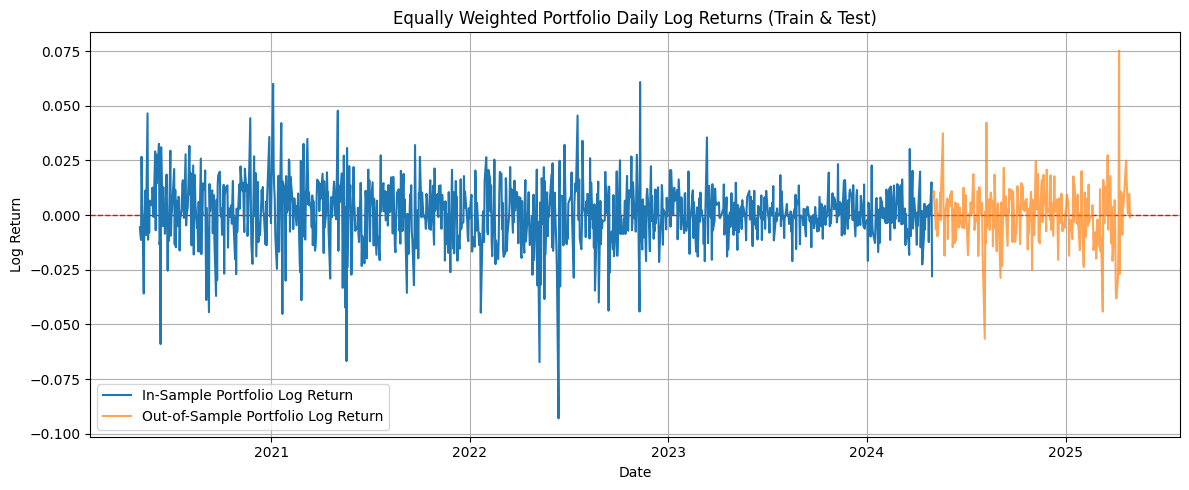

In [11]:
plt.figure(figsize=(12, 5))
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Plot in-sample
plt.plot(log_return_train_df.index, log_return_train_df['portfolio'], label='In-Sample Portfolio Log Return')

# Plot out-of-sample
plt.plot(log_return_test_df.index, log_return_test_df['portfolio'], label='Out-of-Sample Portfolio Log Return', alpha=0.7)

plt.title('Equally Weighted Portfolio Daily Log Returns (Train & Test)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Although diversification should reduce the magnitude of extreme movements compared to individual assets, noticeable fluctuations and persistent periods of high and low volatility still emerge. This justifies further investigation into the portfolio’s volatility dynamics using conditional heteroskedasticity models.

### 2.2 Squared Log Returns

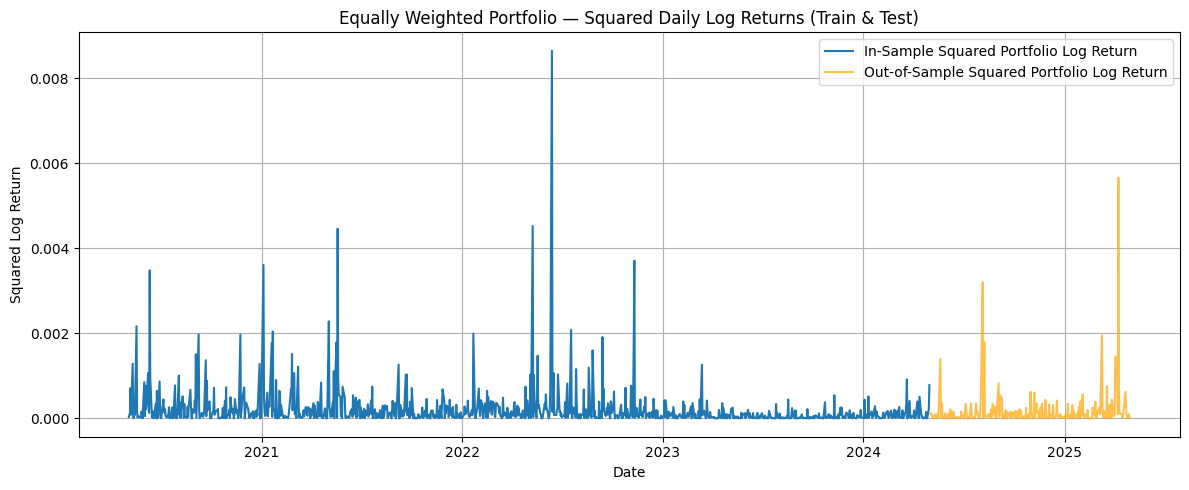

In [11]:
import matplotlib.pyplot as plt

# Step 5: Calculate squared log returns for the portfolio
log_return_train_df['squared_portfolio_return'] = log_return_train_df['portfolio'] ** 2
log_return_test_df['squared_portfolio_return'] = log_return_test_df['portfolio'] ** 2

# Step 6: Plot squared log returns of the equally weighted portfolio
plt.figure(figsize=(12, 5))

# Plot in-sample squared returns
plt.plot(log_return_train_df.index, log_return_train_df['squared_portfolio_return'],
         label='In-Sample Squared Portfolio Log Return')

# Plot out-of-sample squared returns
plt.plot(log_return_test_df.index, log_return_test_df['squared_portfolio_return'],
         label='Out-of-Sample Squared Portfolio Log Return', color='orange', alpha=0.7)

# Plot formatting
plt.title('Equally Weighted Portfolio — Squared Daily Log Returns (Train & Test)')
plt.xlabel('Date')
plt.ylabel('Squared Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


---
# **Returns Stylized Facts** (da aggiustare i commenti)

# 1. Commenting on possible *leptokurtosis* of log-returns

In this section, we examine the well-known empirical regularities of financial asset returns.  Specifically, we verify that daily log-returns typically display:

- **Mean close to zero**, indicating no persistent drift over time.  
- **Leptokurtosis**, with heavier tails than a Gaussian distribution.  
- **Approximate symmetry**, or mild negative skew, reflecting slightly more extreme down-moves.  
- **Weak autocorrelation**, consistent with the weak-form Efficient Market Hypothesis.

We will quantify these features via summary statistics, the Jarque–Bera normality test, and the Ljung–Box test for serial dependence. 


**NB**: *The analysis of stylized facts is performed only on the in-sample data because it is used to understand the statistical properties of the time series, such as volatility clustering, leptokurtosis, and the presence of ARCH effects. These characteristics guide the model selection and specification. The out-of-sample data is reserved for evaluating the forecasting performance of the fitted models and must remain untouched during model development to ensure a fair and unbiased assessment.*


In [12]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

lb_lags = [10]
results = []

# 1) Loop over each in-sample asset
for name, df in assets_train.items():
    df = df.copy()
    r = np.log(df['Close']).diff().dropna()

    # Jarque-Bera test
    jb_stat, jb_pvalue, skew, kurtosis_excess = jarque_bera(r)

    # Ljung–Box test for autocorrelation
    lb = acorr_ljungbox(r, lags=lb_lags, return_df=True)
    lb_stat = lb['lb_stat'].iloc[0]
    lb_pvalue = lb['lb_pvalue'].iloc[0]

    results.append({
        'Asset': name.upper(),
        'Mean(r)': r.mean(),
        'Skew(r)': skew,
        'Kurtosis(r)': kurtosis_excess + 3,  # convert to normal kurtosis
        'JB Stat': jb_stat,
        'JB p-value': jb_pvalue,
        f'LB{lb_lags[0]} Stat': lb_stat,
        f'LB{lb_lags[0]} p-value': lb_pvalue
    })

# 2) Equally weighted portfolio log-returns (in-sample)
rets = pd.concat(
    [np.log(df['Close']).diff() for df in assets_train.values()],
    axis=1
)
rets.columns = list(assets_train.keys())
rets = rets.dropna()

port_r = rets.mean(axis=1)

# Portfolio tests
jb_stat, jb_pvalue, skew, kurtosis_excess = jarque_bera(port_r)
lb = acorr_ljungbox(port_r, lags=lb_lags, return_df=True)
lb_stat = lb['lb_stat'].iloc[0]
lb_pvalue = lb['lb_pvalue'].iloc[0]

results.append({
    'Asset': 'PORTFOLIO',
    'Mean(r)': port_r.mean(),
    'Skew(r)': skew,
    'Kurtosis(r)': kurtosis_excess + 3,
    'JB Stat': jb_stat,
    'JB p-value': jb_pvalue,
    f'LB{lb_lags[0]} Stat': lb_stat,
    f'LB{lb_lags[0]} p-value': lb_pvalue
})

# 3) Summary table
summary_df = pd.DataFrame(results)
summary_df.index = np.arange(1, len(summary_df) + 1)

# Display
summary_df

Asset  Mean(r)  Skew(r)  Kurtosis(r)    JB Stat  JB p-value  LB10 Stat  \
1       GSPC  0.00057 -0.42759      8.24913  242.45195     0.00000   18.03505   
2         BA  0.00023  0.22472     10.64332  911.30264     0.00000   19.79610   
3    ETH-USD  0.00263 -0.20633     12.16579 1599.08976     0.00000   17.58512   
4     USDPLN -0.00003  0.12024      8.14865  195.74656     0.00000   26.63574   
5       GOLD  0.00030 -0.54945      8.53903  320.52313     0.00000   16.71836   
6  PORTFOLIO  0.00074 -0.54238      9.69342  620.50495     0.00000   21.01022   

   LB10 p-value  
1       0.05438  
2       0.03124  
3       0.06238  
4       0.00297  
5       0.08083  
6       0.02102

In [13]:
#save as CSV for further analysis
summary_df.to_csv('../data/results/stylized_facts_summary.csv', index=False)

## 1.1 Summary of Stylized Facts for In-Sample Log Returns

The statistical summary confirms the presence of several classic stylized facts in daily log returns:

- **Mean close to zero**: All assets show an average return near zero, from –0.00003 for USDPLN to +0.00181 for ETH-USD, consistent with no strong drift in daily movements.

- **Leptokurtosis**: All series display **excess kurtosis**, far above the Gaussian benchmark of 3. Kurtosis values range from ~8.25 for GSPC to over 11 for ETH-USD, reflecting frequent extreme returns and fat tails—typical of financial time series.

- **Mild skewness**: Skewness is moderate in magnitude. Most assets show slight negative asymmetry (GSPC, ETH-USD, GOLD, and the portfolio), while BA and USDPLN have mild positive skewness. These values indicate that return distributions are not perfectly symmetric.

- **Jarque–Bera test**: All assets have **very small p-values** (e.g., p < 1e-50), strongly rejecting the null hypothesis of normality. This reinforces the presence of both skewness and excess kurtosis.

- **Ljung–Box(10) test**: The test indicates **significant autocorrelation** in returns for BA, ETH-USD, USDPLN, and the equally-weighted portfolio (p < 0.05), while GSPC and GOLD are borderline. This suggests that raw return series are not fully white noise and may contain weak short-term memory, possibly due to microstructure effects or market inefficiencies.

These findings support the use of GARCH-type models to capture volatility dynamics, especially given the non-normality and serial dependence in returns.



## 1.2 Distributional Assessment via **KDE** and **QQ-Plots** (da aggiustare i commenti)

To complement the formal normality tests, we juxtapose each series’ empirical kernel‐density estimate (KDE) of its log-returns against the density of a Gaussian law with the same mean and variance, and we accompany that with a QQ-plot versus the matching theoretical normal quantiles.  The KDE highlights how the bulk and the tails of the true distribution depart from the bell curve, while the QQ-plot makes those departures explicit: systematic “S-shapes” betray leptokurtosis, and asymmetries around the 45° line flag skew.  Together, these visuals give an immediate sense of tail thickness, central peak height, and any bias in the left or right tail, all key stylized facts of financial returns.


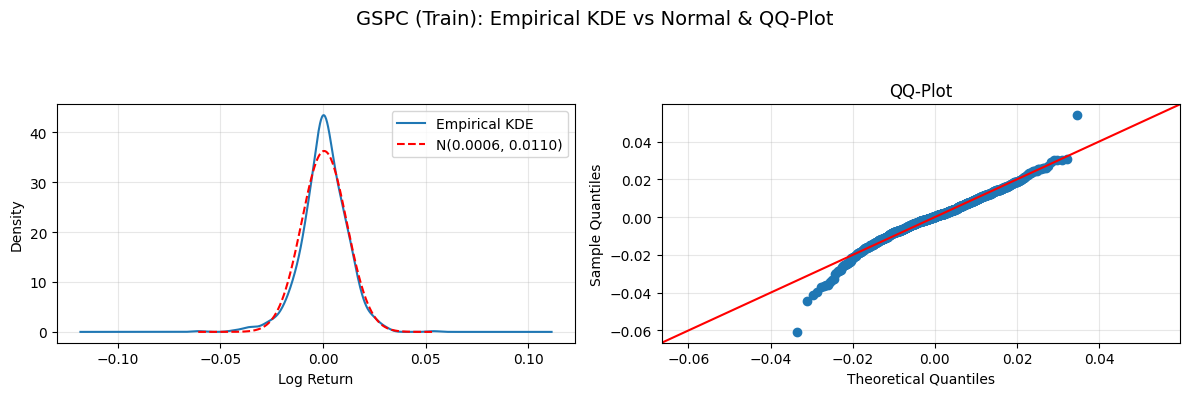

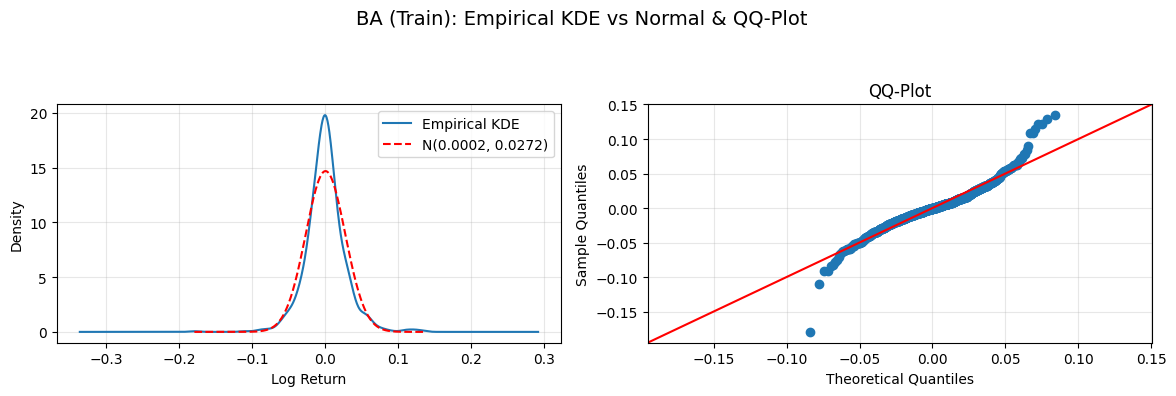

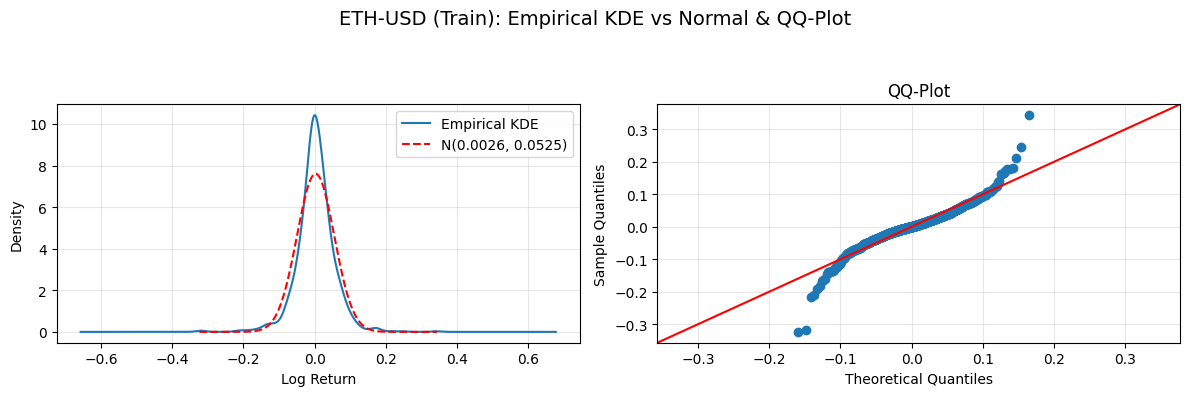

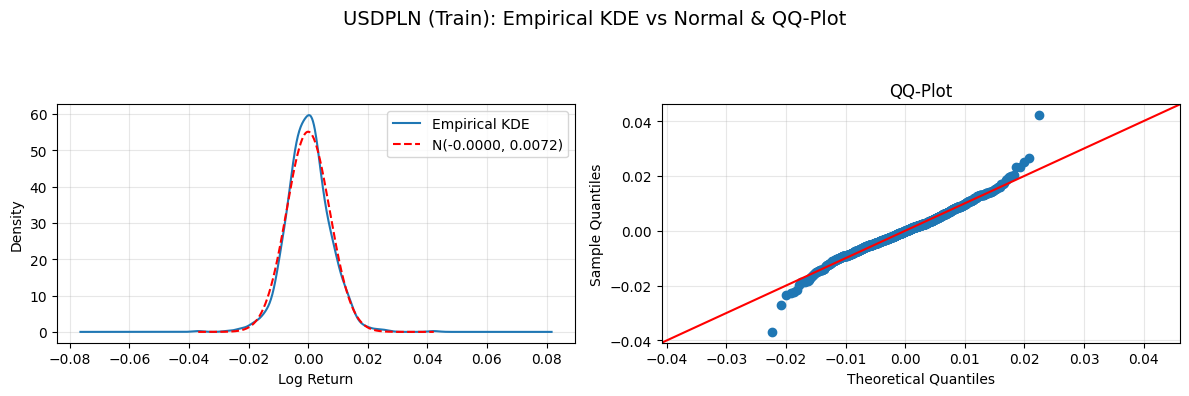

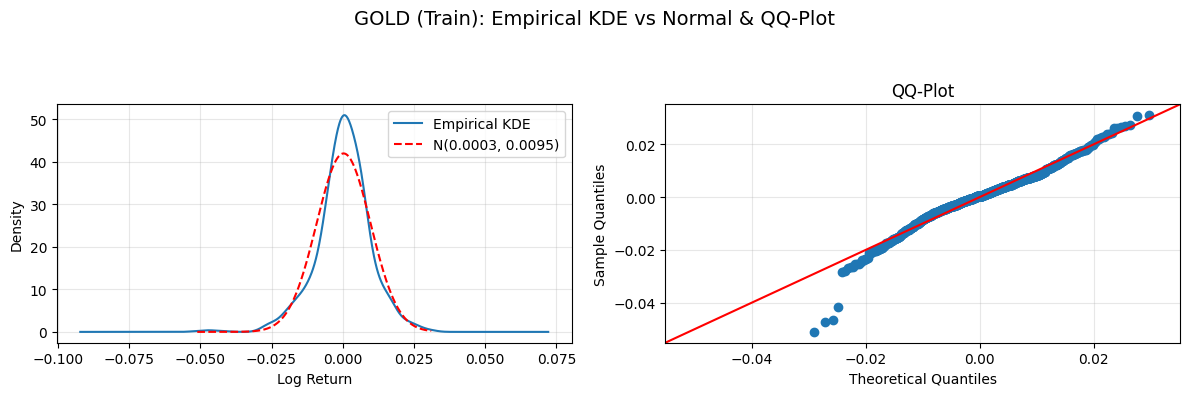

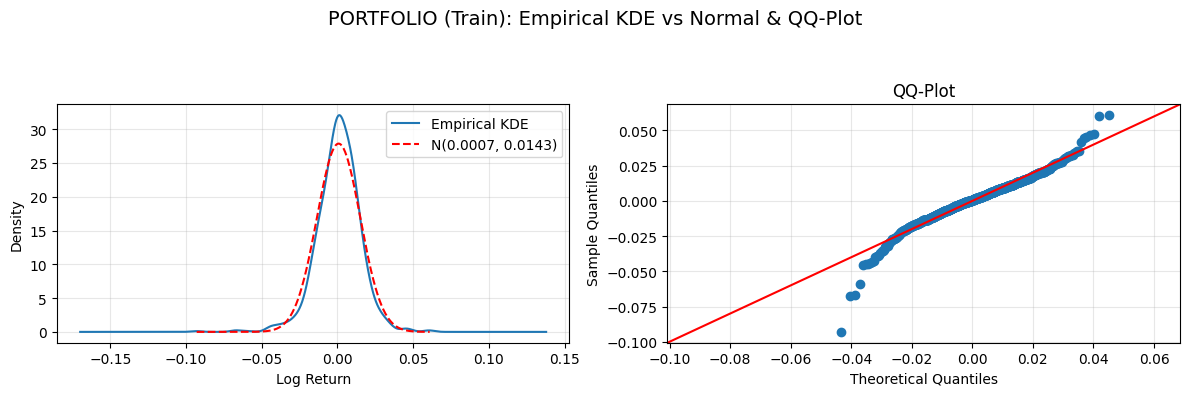

In [14]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# Step 1: Compute log-returns for each asset (train only)
returns_dict = {}
for name, df in assets_train.items():
    r = np.log(df['Close']).diff().dropna()
    returns_dict[name.upper()] = r

# Step 2: Compute equally-weighted portfolio log-returns
asset_names = list(returns_dict.keys())
weights = np.repeat(1/len(asset_names), len(asset_names))
aligned = pd.concat([returns_dict[n] for n in asset_names], axis=1).dropna()
aligned.columns = asset_names
portfolio_r = aligned.dot(weights)
returns_dict['PORTFOLIO'] = portfolio_r

# Step 3: Plot KDE + QQ-Plot for each in-sample series
for name, r in returns_dict.items():
    mu, sigma = r.mean(), r.std()
    x_min, x_max = r.min(), r.max()
    x = np.linspace(x_min, x_max, 500)
    pdf = norm.pdf(x, loc=mu, scale=sigma)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{name} (Train): Empirical KDE vs Normal & QQ‐Plot", fontsize=14)

    # 1) Density plot
    ax = axes[0]
    r.plot(kind='density', ax=ax, label='Empirical KDE')
    ax.plot(x, pdf, 'r--', label=f'N({mu:.4f}, {sigma:.4f})')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

    # 2) QQ‐Plot
    ax = axes[1]
    sm.qqplot(r, line='45', ax=ax, dist=norm, loc=mu, scale=sigma)
    ax.set_title('QQ‐Plot')
    ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# 2. Investigating **volatility stylized facts**


In this section, we explore the stylized facts of financial volatility, which are essential for understanding the empirical behavior of asset returns and for motivating the use of certain conditional volatility models.

In order to do so, a brief explanaton of the volatility is required:
Volatility is closely related to the likelihood of observing extreme values in asset returns — whether very high or very low. However, from a statistical perspective, volatility must be clearly distinguished from the unconditional variance of returns.
In fact, volatility is a forward-looking measure of risk: given a planned holding period [t,t+k] volatility is defined as the conditional variance of returns over that horizon, based on the information available at time 
𝑡. Formally:

$$
v_{t+k,k}=Var(r_{t+k,k}|\mathcal{I_t})=E[r^2_{t+k,k}|\mathcal{I_t}]-(E[r_{t+k,k}|\mathcal{I_t}])^2
$$

By conditioning on the information set $\mathcal{I_t}$, volatility becomes state-dependent, adapting to current market conditions. This is in stark contrast to the unconditional variance, which assumes constant risk over time and across all scenarios.
As a result, volatility is considered a latent variable — it cannot be observed directly, but must be inferred through appropriate models.
To study volatility empirically, we rely on observable proxies. In this analysis, we adopt the squared log-returns as our primary proxy. This choice is both practical and theoretically sound, as squared returns reflect the magnitude of return fluctuations regardless of direction and align naturally with the structure of ARCH and GARCH models; indeed, if we assume (and, in general, this hypothesis is true) that the returns are zero mean, the squared log-return is an unbiased estimator for the volatility:
$$
E[v_t]=E[r^2_t]
$$

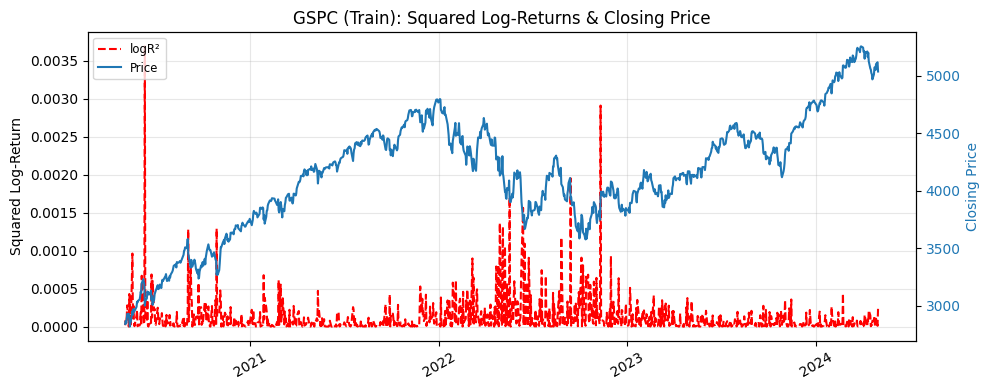

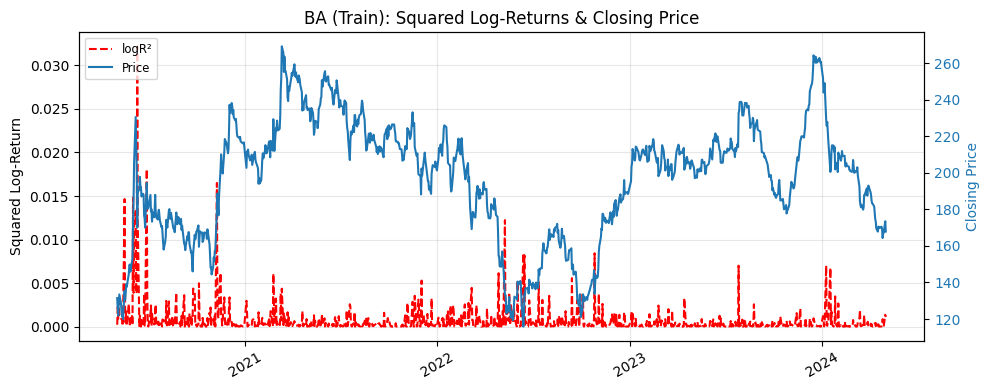

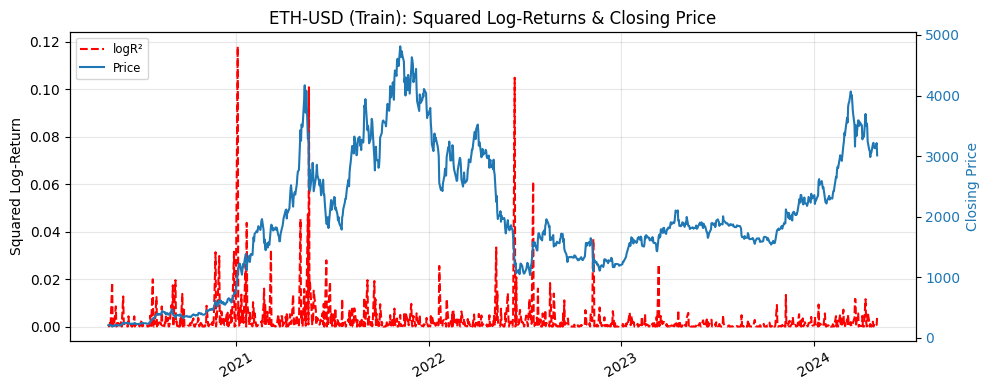

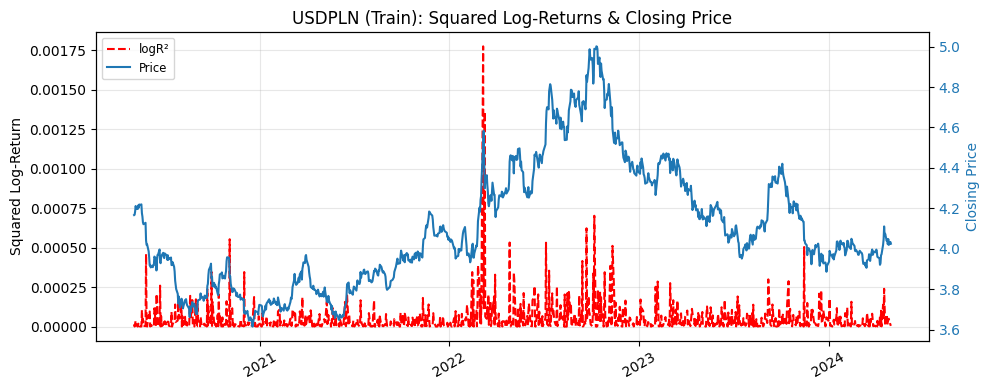

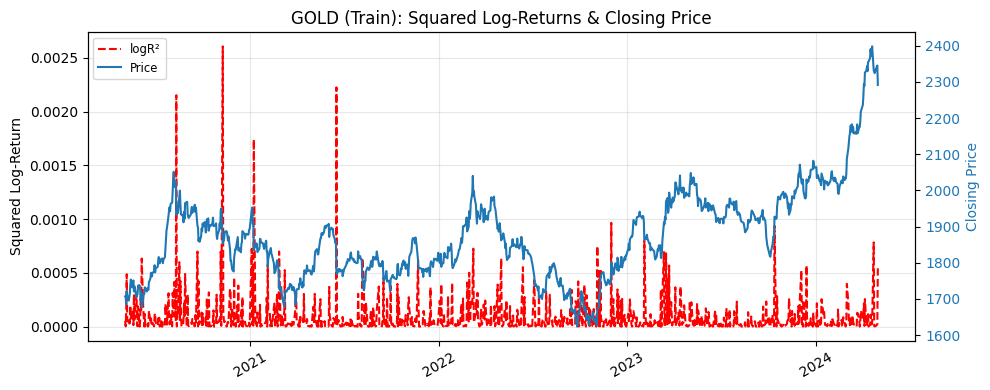

In [15]:
# Mapping of in-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# Loop over in-sample assets
for name, df in assets_train.items():
    if 'Close' not in df.columns:
        continue

    # Prepare DataFrame
    df = df.copy()
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['Close']).diff()
    df = df.dropna(subset=['log_return'])

    # Create figure and primary axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # 1) Plot squared log‐returns (red dashed)
    ax.plot(
        df.index,
        df['log_return'] ** 2,
        linestyle='--',
        color='red',
        label="logR²"
    )
    ax.set_ylabel('Squared Log-Return')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3)

    # 2) Plot closing price on secondary axis
    ax2 = ax.twinx()
    ax2.plot(
        df.index,
        df['Close'],
        linestyle='-',
        color='#1f77b4',
        label=f'Price'
    )
    ax2.set_ylabel('Closing Price', color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4')

    # 3) Combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(
        h1 + h2,
        l1 + l2,
        loc='upper left',
        fontsize='small'
    )

    # Title and layout
    plt.title(f'{name.upper()} (Train): Squared Log-Returns & Closing Price')
    plt.tight_layout()
    plt.show()


In these dual‐axis charts, the solid blue line represents the daily closing price and the red dashed line shows the squared log‐returns. Squaring returns compresses small fluctuations toward zero while dramatically amplifying larger moves, making high‐volatility spikes immediately apparent. Calm phases appear as an almost flat red band beneath a smooth price curve, whereas turbulent periods—such as during financial shocks or major news events—produce clustered red peaks corresponding to substantial price swings. This clearly separates low‐volatility regimes from turbulent ones and demonstrates squared log‐returns’ effectiveness as a volatility proxy.
Indeed,these bursts of elevated squared returns, followed by stretches of near‐zero activity, are the hallmark of volatility clustering:

1. Clusters of tall red peaks correspond to sustained high‐volatility episodes, not just single shocks.

2. Flat red bands align with quieter market phases, showing volatility remaining persistently low.

Because those spikes tend to appear in runs (and not randomly), they exhibit positive autocorrelation: high volatility begets more high volatility, and low begets low. That very persistence—clearly visible in the way the red spikes bunch together on the time axis—is what ARCH/GARCH models are designed to capture.

This clustering pattern can be formally tested by examining the autocorrelation function (ACF) of the squared log-returns. Under volatility clustering, the ACF of $r_t^2$​ will display significantly positive values at multiple lags, indicating that today’s large squared return predicts tomorrow’s. In statistical terms, volatility clustering is nothing more than a strong positive autocorrelation structure in the latent variance process.

As a complementary check, one can also plot the ACF of **absolute** log‐returns $|r_{t}|$.  Although $|r_{t}|$ is a biased proxy for conditional variance, its ACF tends to be smoother and easier to read—still revealing the same long‐memory clustering in volatility without the extreme leverage of squaring. 

#### Portfolio task


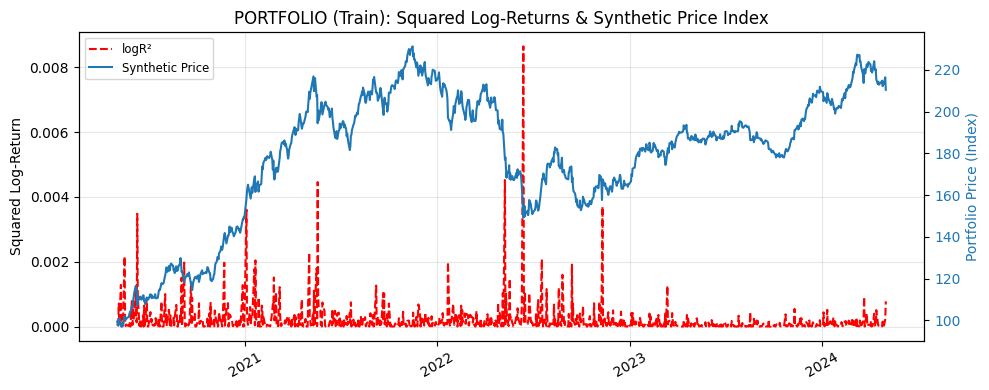

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Step: Prepare portfolio DataFrame
portfolio_train_df = log_return_train_df[['portfolio']].copy()
portfolio_train_df['log_return'] = portfolio_train_df['portfolio']
portfolio_train_df['log_return_sq'] = portfolio_train_df['log_return'] ** 2

# Compute portfolio price index by reversing log returns
# Assume base price 100
portfolio_train_df['Close'] = 100 * np.exp(portfolio_train_df['log_return'].cumsum())

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

# 1) Plot squared log‐returns
ax.plot(
    portfolio_train_df.index,
    portfolio_train_df['log_return_sq'],
    linestyle='--',
    color='red',
    label="logR²"
)
ax.set_ylabel('Squared Log-Return')
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=30)
ax.grid(True, alpha=0.3)

# 2) Plot synthetic portfolio price on secondary axis
ax2 = ax.twinx()
ax2.plot(
    portfolio_train_df.index,
    portfolio_train_df['Close'],
    linestyle='-',
    color='#1f77b4',
    label='Synthetic Price'
)
ax2.set_ylabel('Portfolio Price (Index)', color='#1f77b4')
ax2.tick_params(axis='y', labelcolor='#1f77b4')

# 3) Combine legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc='upper left', fontsize='small')

# Title and layout
plt.title('PORTFOLIO (Train): Squared Log-Returns & Synthetic Price Index')
plt.tight_layout()
plt.show()


# 3. ARCH effects among log-returns, autocorrelation of squared returns,

## 3.1 Squared log returns - AutoCorrelation Function - ACF 

### 3.1.1 Squared log returns ACF of single indeces

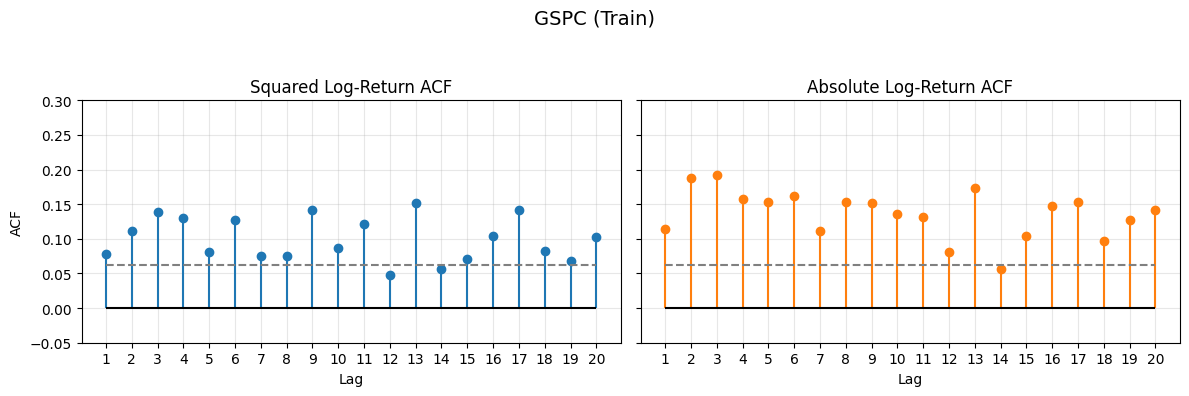

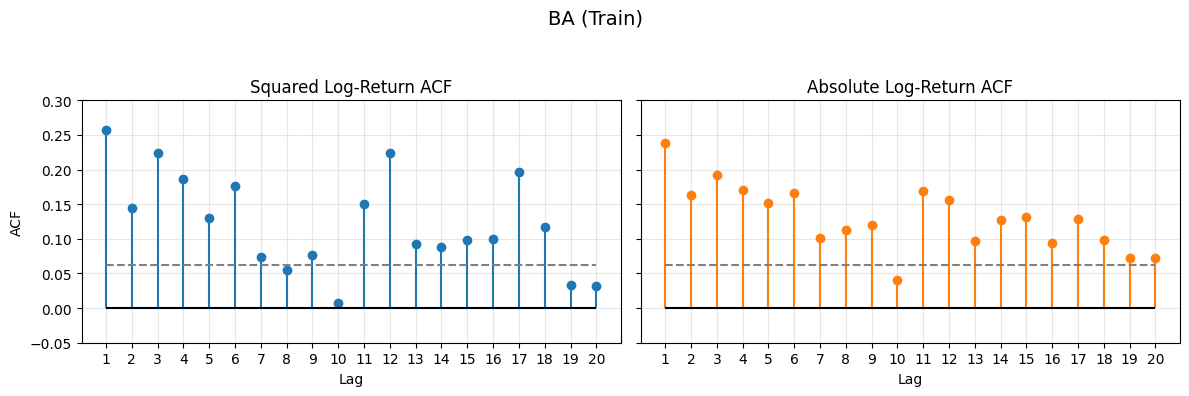

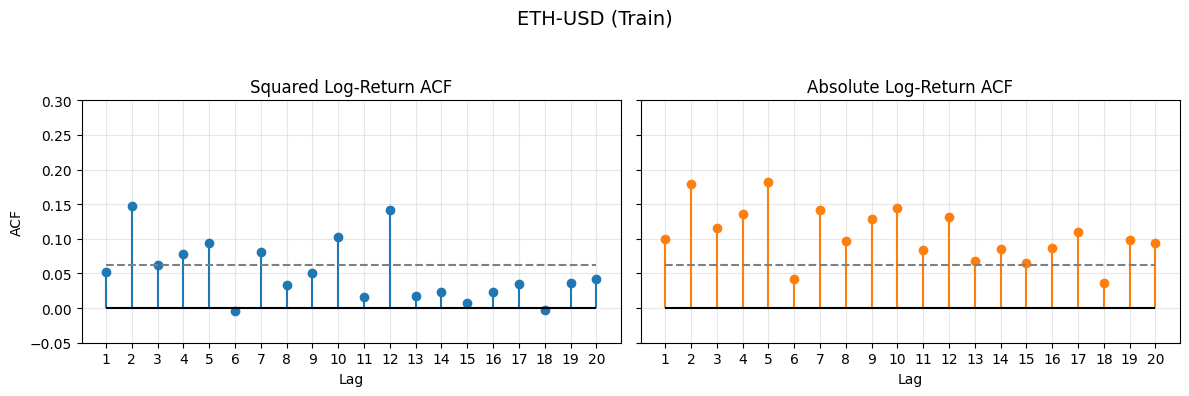

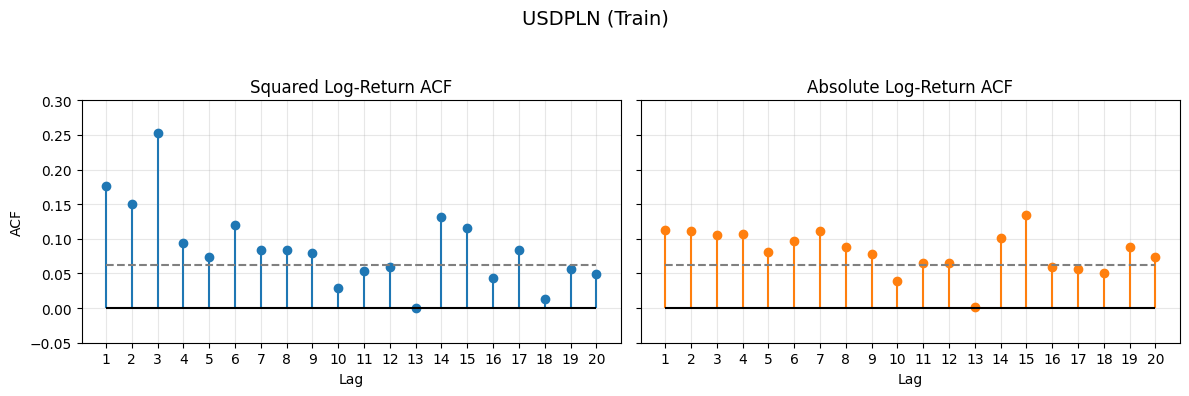

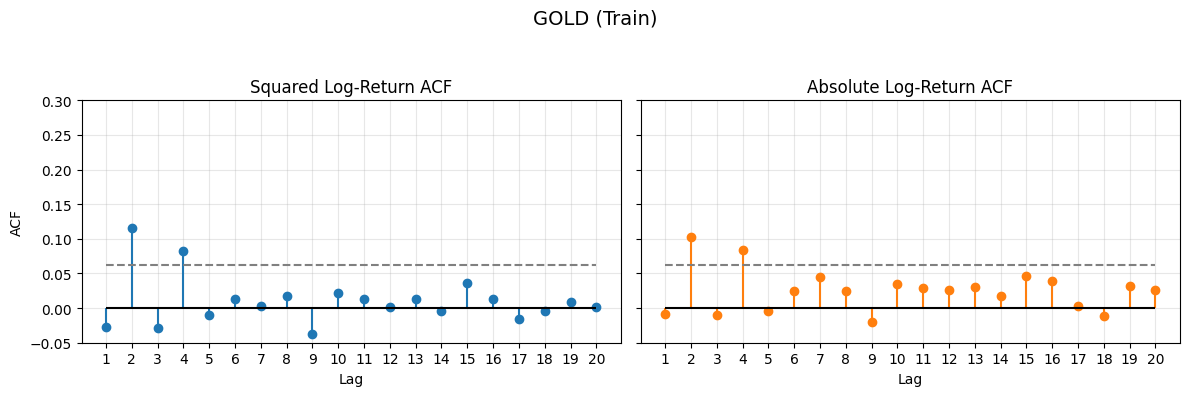

In [16]:
# In-sample data
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

nlags = 20

for name, df in assets_train.items():
    df = df.copy()
    log_ret = np.log(df['Close']).diff().dropna()
    r2 = log_ret ** 2
    r_abs = log_ret.abs()

    # ACF computation
    acf2 = acf(r2, nlags=nlags, fft=False)
    acf_abs = acf(r_abs, nlags=nlags, fft=False)
    N = len(log_ret)
    conf = 1.96 / np.sqrt(N)
    lags = np.arange(1, nlags + 1)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    fig.suptitle(f"{name.upper()} (Train)", fontsize=14)

    # Squared returns ACF
    axes[0].stem(lags, acf2[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
    axes[0].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
    axes[0].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
    axes[0].set_title("Squared Log-Return ACF")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")
    axes[0].set_xticks(lags)
    axes[0].set_ylim(-0.05, 0.30)
    axes[0].grid(alpha=0.3)

    # Absolute returns ACF
    axes[1].stem(lags, acf_abs[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
    axes[1].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
    axes[1].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
    axes[1].set_title("Absolute Log-Return ACF")
    axes[1].set_xlabel("Lag")
    axes[1].set_xticks(lags)
    axes[1].set_ylim(-0.05, 0.30)
    axes[1].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


### 3.1.2 ACF of entire balanced portfolio

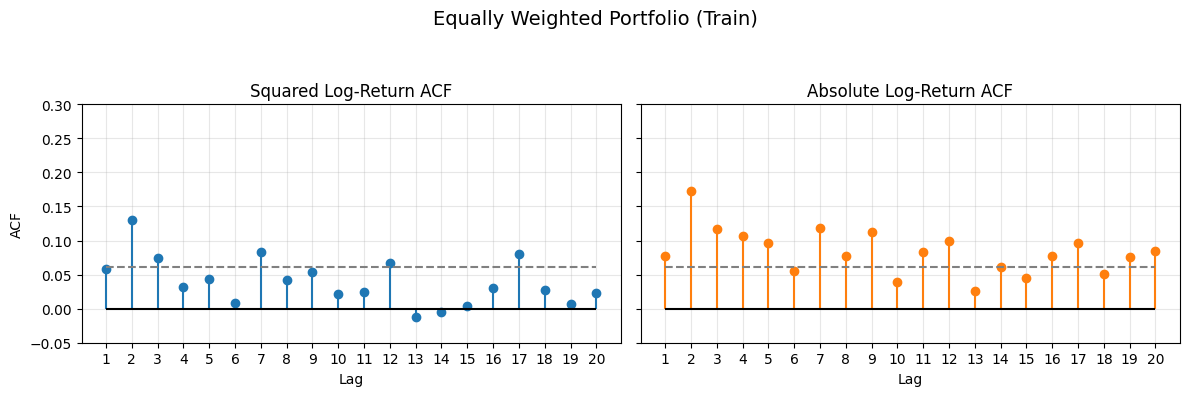

In [17]:
nlags = 20 #same  of lags

# Usa i log-return in-sample del portafoglio già calcolati
port_ret = log_return_train_df['portfolio'].dropna()

# Serie al quadrato e assoluta
r2 = port_ret**2
r_abs = port_ret.abs()

# Calcola ACF e bande di confidenza
acf2 = acf(r2, nlags=nlags, fft=False)
acf_abs = acf(r_abs, nlags=nlags, fft=False)
N = len(port_ret)
conf = 1.96 / np.sqrt(N)
lags = np.arange(1, nlags + 1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle("Equally Weighted Portfolio (Train)", fontsize=14)

# Squared log-return ACF
axes[0].stem(lags, acf2[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
axes[0].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
axes[0].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
axes[0].set_title("Squared Log-Return ACF")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")
axes[0].set_xticks(lags)
axes[0].set_ylim(-0.05, 0.30)
axes[0].grid(alpha=0.3)

# Absolute log-return ACF
axes[1].stem(lags, acf_abs[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
axes[1].hlines([conf, -conf], xmin=1, xmax=nlags, linestyles='--', colors='gray')
axes[1].hlines(0, xmin=1, xmax=nlags, linestyles='-', colors='black')
axes[1].set_title("Absolute Log-Return ACF")
axes[1].set_xlabel("Lag")
axes[1].set_xticks(lags)
axes[1].set_ylim(-0.05, 0.30)
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


Below each panel, focus on the height and persistence of the spikes:

* Magnitude of the bars. Taller bars at early lags mean that large squared (or absolute) returns today tend to be followed by large values tomorrow — a clear signature of volatility clustering.

* Decay pattern. If the bars decline slowly over many lags, it implies that shocks to volatility are long‐lasting. A rapid drop would suggest only very short‐lived clusters.

* Absolute vs. squared. Compare the two series: absolute returns often show even stronger, smoother autocorrelation curves, making persistence easier to spot.

* Confidence bounds. Any spike crossing the dashed horizontal lines is statistically significant. Those are the lags at which past volatility meaningfully predicts future volatility.

In practice, these features tell us that volatility is far from “white noise” — it has memory. That memory is exactly what ARCH/GARCH families exploit when they model today’s variance as a function of yesterday’s shocks (and/or its previous values). In our case

1. S&P 500 (GSPC)
 

The S&P 500 exhibits clear volatility clustering: its squared‐return ACF shows multiple significant spikes at lags 1, 3–4, 9, 13–14, 16–17 and beyond, and the absolute‐return ACF is even stronger and smoother. This persistence—shocks to volatility leaving a long “memory”—is the hallmark of an ARCH effect.

2. Boeing (BA)

Boeing’s squared‐return ACF starts extremely high at lag 1 (≈ 0.26), then decays slowly with further significant spikes at lags 3–4, 6, 9, 12 and 16. Its absolute‐return ACF mirrors this pattern. Such slow decay and high early autocorrelations point to very pronounced heteroskedasticity and strong ARCH-type dynamics.

3. Ethereum USD (ETHUSD)

Ethereum’s squared‐return ACF has pronounced peaks at lags 2, 4, 7 and 10, and remains above significance out to lag 20; the absolute‐return ACF is comparably persistent. Although slightly less “peaky” than equities, crypto returns still display robust volatility clustering, indicating that large intraday moves beget further large moves.

4. USD/PLN Exchange Rate (PLNX)

The USD/PLN pair shows moderate but significant autocorrelation in squared returns at lags 1, 3, 4 and 7–8, with a more rapid decay thereafter; the absolute‐return ACF is weaker but still above the confidence bounds at several early lags. This suggests milder heteroskedasticity than stocks or crypto, yet still a detectable ARCH effect in currency markets.

5. Gold (GCF)

Gold’s squared‐return ACF peaks mainly at lag 2, with only this lag
 crossing significance—subsequent autocorrelations hover near zero. The absolute‐return ACF likewise shows a couple of early significant bars. This pattern implies that gold volatility clusters only briefly: shocks have shorter lives, and the ARCH effect is far weaker here than in other assets.

* Equally-Weighted Portfolio

The aggregated portfolio retains clear volatility clustering in both squared and absolute returns—significant at lags 1–3, 7, 12 and 16—though peak autocorrelations are dampened relative to the most volatile components. This confirms that, even after diversification, conditional heteroskedasticity persists: today’s portfolio variance remains a strong predictor of tomorrow’s. Such findings justify the use of GARCH-family models at the portfolio level as well.











## 3.2 Testing for ARCH effects

As previously mentioned, the strong persistence we observed in the autocorrelations of squared (and absolute) returns reflects the presence of **ARCH effects**, or autoregressive conditional heteroskedasticity.  ARCH effects arise whenever current volatility depends on past squared shocks, causing variance to evolve through time rather than remain constant.  Testing for ARCH effects is therefore a crucial diagnostic step: it confirms whether a simple constant‐variance model is inadequate and whether more sophisticated volatility models are warranted.  In practice, detecting ARCH effects guides us to formally specify and estimate the correct conditional‐variance structure.  

To formally confirm the presence of ARCH effects, we apply Engle's ARCH test, which is based on the autocorrelation between squared log returns.




In [18]:
from statsmodels.stats.diagnostic import het_arch

results = {}

# Dati in-sample (train)
assets_train = {
    'GSPC': gspc_train,
    'BA': ba_train,
    'ETH-USD': eth_train,
    'USDPLN': usdpln_train,
    'GOLD': gold_train
}

# 1) ARCH test su ogni asset in-sample
for name, df in assets_train.items():
    df = df.copy()
    log_ret = np.log(df['Close']).diff().dropna()
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(log_ret, nlags=5)
    results[name] = {
        'LM Stat': lm_stat,
        'LM p-value': lm_pvalue,
        'F Stat': f_stat,
        'F p-value': f_pvalue
    }

# 2) ARCH test sul portafoglio equally-weighted (in-sample)
# Assicurati che le colonne siano allineate per calcolo corretto
rets_train = pd.concat(
    [np.log(df['Close']).diff() for df in assets_train.values()],
    axis=1
).dropna()
rets_train.columns = list(assets_train.keys())

port_ret = rets_train.mean(axis=1)

lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(port_ret, nlags=5)
results['Portfolio'] = {
    'LM Stat': lm_stat,
    'LM p-value': lm_pvalue,
    'F Stat': f_stat,
    'F p-value': f_pvalue
}

# 3) Visualizza i risultati
for key, res in results.items():
    print(f"--- {key} ---")
    print(f"LM Statistic: {res['LM Stat']:.3f}   p-value: {res['LM p-value']:.3f}")
    print(f"F Statistic:  {res['F Stat']:.3f}   p-value: {res['F p-value']:.3f}")
    print()


--- GSPC ---
LM Statistic: 45.294   p-value: 0.000
F Statistic:  9.432   p-value: 0.000

--- BA ---
LM Statistic: 113.083   p-value: 0.000
F Statistic:  25.347   p-value: 0.000

--- ETH-USD ---
LM Statistic: 34.527   p-value: 0.000
F Statistic:  7.109   p-value: 0.000

--- USDPLN ---
LM Statistic: 90.855   p-value: 0.000
F Statistic:  19.867   p-value: 0.000

--- GOLD ---
LM Statistic: 19.710   p-value: 0.001
F Statistic:  3.997   p-value: 0.001

--- Portfolio ---
LM Statistic: 24.310   p-value: 0.000
F Statistic:  4.953   p-value: 0.000



In [19]:
# automatize the display of ARCH effects and comparsion between assets
for name, res in results.items():
    lm_pval = res['LM p-value']
    f_pval = res['F p-value']
    arch_present = "YES" if lm_pval < 0.05 or f_pval < 0.05 else "NO"

    print(f"--- {name} ---")
    print(f"ARCH Effects Present: {arch_present}")
    print()

--- GSPC ---
ARCH Effects Present: YES

--- BA ---
ARCH Effects Present: YES

--- ETH-USD ---
ARCH Effects Present: YES

--- USDPLN ---
ARCH Effects Present: YES

--- GOLD ---
ARCH Effects Present: YES

--- Portfolio ---
ARCH Effects Present: YES



The results of the LM-ARCH test (Engle's test) conducted on in-sample daily log-returns for all individual assets and the equally-weighted portfolio are reported below. The test examines whether there is significant conditional heteroskedasticity (ARCH effects) in the return series.

All p-values for both the LM and F statistics are below the conventional significance threshold of 0.05. This implies that we **reject the null hypothesis of no ARCH effects** for all series.

| Asset      | LM p-value | F p-value | ARCH Effects Present? |
|------------|------------|-----------|------------------------|
| GSPC       | 0.000      | 0.000     | YES                    |
| BA         | 0.000      | 0.000     | YES                    |
| ETH-USD    | 0.000      | 0.000     | YES                    |
| USDPLN     | 0.000      | 0.000     | YES                    |
| GOLD       | 0.001      | 0.001     | YES                    |
| Portfolio  | 0.000      | 0.000     | YES                    |

The automated test correctly flags the **presence of ARCH effects** in all series based on statistically significant results. This supports the use of GARCH-type models for volatility modeling and forecasting.


---

# MI SONO FERMATO QUI
---

## Leverage Effect (DA CAPIRE COME IMPLEMENTARE IN PYTHON LA EMPIRICAL NEWS IMPACT CURVE E/O SCATTERPLOT R^2 VS LOG RETURN LAGGATI)
Continuing from our discussion of persistence in volatility, the **leverage effect** highlights an important asymmetry in how bad news and good news impact future risk. Empirically, volatility often rises more sharply after negative returns than after positive returns of the same size. In statistical terms, this means that estimates of today’s volatility tend to be negatively correlated with yesterday’s return. 

Black (1976) and Christie (1982) tied this behavior to financial leverage: when a firm’s share price falls, its debt-to-equity ratio climbs, signaling higher risk and thus higher expected volatility. To explore the leverage effect, one can:

1. **Plot an empirical “news impact curve”** by graphing the volatility versus the lagged returns. A steeper increase on the negative-return side confirms that downward shocks amplify volatility more than upward shocks.

Capturing this asymmetric response is key to accurate volatility modeling and motivates the use of asymmetric GARCH specifications (e.g., EGARCH, GJR-GARCH) that allow negative returns to have a larger effect on future variance.


In [ ]:
# Identify assets with price data
assets = [name for name, df in data_dict.items() if 'Close' in df.columns]

# Prepare subplots: 5 rows x 1 column
fig, axes = plt.subplots(len(assets), 1, figsize=(8, 4*len(assets)), sharex=False)
fig.suptitle("Empirical News Impact Curves for All Assets", fontsize=16, y=0.92)

for ax, name in zip(axes, assets):
    df = data_dict[name].copy()
    # Compute daily log-returns and drop NaNs
    df['r'] = np.log(df['Close']).diff()
    df = df.dropna()
    
    # Volatility proxy = squared log-returns
    df['vol'] = df['r']**2
    # Lagged return
    df['r_lag1'] = df['r'].shift(1)
    df = df.dropna()
    
    x = df['r_lag1']
    y = df['vol']
    
    # LOWESS smoothing
    smoothed = lowess(y, x, frac=0.3)
    
    # Scatter + LOWESS
    ax.scatter(x, y, alpha=0.3, s=10, label='Observed')
    ax.plot(smoothed[:,0], smoothed[:,1], 'r--', linewidth=2, label='LOWESS Fit')
    
    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{name.upper()}")
    ax.set_ylabel("Volatility Proxy (r²)")
    ax.legend()
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Lagged Return $r_{t-1}$")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Portfolio Volatility

In a portfolio composed of $m$ assets, the portfolio return at time $t$ is defined as a weighted average of individual asset log-returns:

$$
r_t^{(p)} = \sum_{i=1}^m w_{t,i} \, r_{t,i}
$$

where $r_{t,i}$ is the log-return of asset $i$, and $w_{t,i}$ is the portfolio weight assigned to asset $i$ at time $t$.

The conditional variance of the portfolio return—i.e., the **portfolio volatility**—is given by:

$$
v_t^{(p)} = \operatorname{Var}(r_t^{(p)} \mid \mathcal{I}_{t-1}) = \sum_{i=1}^m w_{t,i}^2 \, v_{t,ii} + \sum_{i \ne j} w_{t,i} w_{t,j} \, v_{t,ij}
$$

where $v_{t,ii}$ are the conditional variances and $v_{t,ij}$ the conditional covariances between assets $i$ and $j$.

Alternatively, this can be expressed in matrix form as:

$$
v_t^{(p)} = w_t^\top V_t w_t
$$

where:
- $w_t$ is the vector of portfolio weights $(w_{t,1}, \ldots, w_{t,m})^\top$,
- $V_t$ is the conditional variance-covariance matrix of asset returns.

Using the conditional correlation matrix $R_t$ and a diagonal matrix $D_t$ of conditional standard deviations (i.e., $D_t = \operatorname{diag}(\sqrt{v_{t,11}}, \ldots, \sqrt{v_{t,mm}})$), we can write:

$$
v_t^{(p)} = w_t^\top D_t R_t D_t w_t
$$

This formulation allows to decompose portfolio variance into standard deviations and correlations, which is particularly useful in risk modeling and optimization.


Two main approaches can be adopted:

- **Direct approach**: this method involves modeling the univariate time series of the portfolio returns directly, applying standard volatility measures such as rolling standard deviation or univariate GARCH models. This approach treats the portfolio as a single asset.

- **Indirect approach**: in contrast, this method acknowledges that portfolio volatility depends both on the individual volatilities of the assets and on their covariances (co-volatilities). The indirect approach involves estimating the conditional variances and covariances of the individual assets and combining them according to the formula $v_t^{(p)} = w_t^\top V_t w_t$. This is the more robust and theoretically sound method, especially when dealing with time-varying volatility and correlations.

Notably, only the **indirect approach** allows for portfolio optimization, such as minimizing portfolio variance subject to a target expected return. While the estimation of individual volatilities is relatively straightforward using univariate GARCH models, the estimation of dynamic covariances requires more sophisticated techniques. In the following, we will focus on this indirect approach by modeling each asset's volatility separately and then constructing the portfolio variance from the estimated components.


## Volatility Modeling of Individual Assets

In order to accurately estimate portfolio volatility using the indirect approach, we first need reliable estimates of the conditional variance of each individual asset. For this purpose, we fit volatility models from the GARCH family to each return series. Specifically, we consider three popular specifications: **GARCH** and **EGARCH**. Each of these models captures different features of financial return volatility, such as persistence, asymmetry, and leverage effects.

To determine the most appropriate model for each asset, we perform a model selection procedure based on information criteria (such as the Bayesian Information Criterion, BIC) that will be further explained.

$$
r_t = \mu_t + u_t = \mu_t + z_t h_t
$$

where $z_t$ is an i.i.d. innovation with mean zero and variance one, and $h_t$ is the conditional standard deviation. This assumption simplifies the estimation and focuses the analysis purely on the second moment dynamics, which is justified when the mean is negligible compared to the volatility or when the goal is solely to model time-varying risk.

A key modeling assumption we impose is that the conditional mean of returns is constant - and in some cases equal to zero -, i.e.:

$$
r_t = \mu_t + u_t = \mu + z_t h_t 
$$

From a theoretical standpoint, assuming a constant mean in the return equation simplifies the model without significantly compromising its ability to capture the primary feature of interest: conditional heteroskedasticity. Financial return series are typically weakly autocorrelated in the mean but strongly autocorrelated in the variance. This justifies focusing modeling efforts on the volatility dynamics rather than on a potentially negligible time-varying mean component. Moreover, empirical evidence shows that including autoregressive terms in the mean equation (e.g., AR(1)) often yields limited improvements in forecasting performance while increasing model complexity. Therefore, under the principle of parsimony, we assume $( \mu_t = \mu $), a constant mean.



---

# GARCH(p;q) MODELS
## Interpretation of GARCH Model Parameters

The Generalized Autoregressive Conditional Heteroskedasticity model (GARCH) is used to model and forecast time-varying volatility in financial return series. We recall the general formulation for log-returns:

$$
r_t = \mu_t + u_t = \mu + z_t \sigma_t
$$

where:
- $( r_t )$ is the asset return at time $( t $),
- $( \mu )$ is the constant mean; 
- $( z_t \sim \text{i.i.d. } (0,1) )$ is a standardized innovation, we will assume that it will follow a student's t distribution in order to account for the fat tails in the log returns distribution.
- $( \sigma_t )$ is the conditional standard deviation.

The conditional variance follows a GARCH(p, q) process if and only if:

$$
\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i u_{t-i}^2 + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^2
$$

**Interpretation of parameters**:
- $( \omega > 0 )$: long-term average variance (constant).
- $( \alpha_i \geq 0 )$: impact of past squared residuals ("news").
- $( \beta_j \geq 0 )$: persistence of past volatility (volatility smoothing).
- The sum $( \sum \alpha_i + \sum \beta_j < 1 )$ is required for **stationarity**.

Typically:
- High $( \beta )$ and low $( \alpha )$: shocks decay slowly → persistent volatility.
- High $( \alpha )$: volatility reacts strongly to recent shocks.
- A model where $( \alpha + \beta \approx 1 )$ indicates high **volatility persistence** and slow mean reversion.

These parameters jointly capture the phenomenon of **volatility clustering**, a stylized fact in financial markets.



## **Automated GARCH** Model Selection

This routine automates the process of selecting the best GARCH(p,q) model for a given asset by evaluating several candidate specifications and validating their diagnostics. 

The evaluation metrics used in this automated GARCH model selection—AIC, Ljung–Box tests, and LM ARCH test—are **directly aligned with the criteria explicitly required in the project assignment**. The project instructions specify that model adequacy must be supported by:

- Absence of residual autocorrelation (checked via Ljung–Box on residuals and squared residuals),
- Absence of remaining ARCH effects (verified using the LM ARCH test),
- A well-behaved conditional volatility process.

Therefore, this procedure fully complies with the methodological standards outlined in the assignment brief.

### Step-by-Step Procedure

1. **Model Candidates**  
   The algorithm tests multiple GARCH specifications: (1,1), (2,1), (1,2), and (2,2).  
   Log-returns are rescaled by multiplying by 100 to improve numerical stability during optimization.

2. **Model Estimation**  
   For each $(p,q)$ configuration:
   - A GARCH model is estimated via maximum likelihood.
   - Standardized residuals and squared standardized residuals are extracted.

3. **Model Evaluation Criteria**

#### 1. AIC – Akaike Information Criterion  
Used directly to identify the best model balancing fit and simplicity.  
Formula:  
$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$  
Where $k$ is the number of estimated parameters, and $\hat{L}$ is the maximum likelihood.  
**Lower AIC is better.**

#### 2. BIC – Bayesian Information Criterion  
Also computed for reference but not used for selection.  
It penalizes model complexity more strictly than AIC.

#### 3. Ljung–Box Test (p-value)  
Applied to:
- Standardized residuals → `LB_resid_p`
- Squared residuals → `LB_sqres_p`  

Checks for autocorrelation that should not be present in well-fitted models.  
**Desirable outcome**: p-value $> 0.05$ (fail to reject the null hypothesis of no autocorrelation).

#### 4. LM ARCH Test (p-value)  
Checks for remaining ARCH effects in standardized residuals.  
**Desirable outcome**: p-value $> 0.05$ (no remaining heteroskedasticity).

4. **Best Model Selection**  
The model with the **lowest AIC** is selected **only if**:
- Both Ljung–Box p-values $> 0.05$
- LM ARCH p-value $> 0.05$

If no candidate satisfies all conditions, the lowest-AIC model is still returned, but diagnostics will be flagged for review.

5. **Diagnostics and Visualization**  
For each model, the following plots are generated:
- Conditional volatility
- ACF of standardized residuals (with confidence bands)
- ACF of squared standardized residuals (with confidence bands)


# 1. Indices GARCH estimation
Of course are runned only in IN-SAMPLE, to avoid data leakage
| Asset          | Train DataFrame     | Test DataFrame      |
|----------------|---------------------|----------------------|
| S&P 500        | `gspc_train`        | `gspc_test`          |
| Boeing         | `ba_train`          | `ba_test`            |
| Ethereum (ETH) | `eth_train`         | `eth_test`           |
| USD/PLN        | `usdpln_train`      | `usdpln_test`        |
| Gold           | `gold_train`        | `gold_test`          |

In [20]:
def analyze_garch_for_asset(df, name='Asset'):
    """
    Estimate and diagnose multiple GARCH(p,q) models on a given asset's in-sample log returns,
    and select the best model considering AIC and diagnostic checks.

    Parameters:
        df (pd.DataFrame): In-sample price DataFrame with a 'Close' column
        name (str): Asset name for labeling

    Returns:
        dict: Information about the best GARCH model (based on AIC + diagnostics)
    """
    from arch import arch_model
    from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
    from statsmodels.tsa.stattools import acf
    import matplotlib.pyplot as plt
    import numpy as np

    orders = [(1,1), (2,1), (1,2), (2,2)]
    results = []

    r = 100 * np.log(df['Close']).diff().dropna()  # rescaled log-returns --> are 100X

    print(f"\n=== GARCH Model Estimation & Diagnostics for {name.upper()} ===")

    for p, q in orders:
        try:
            model = arch_model(r, vol='GARCH', p=p, q=q, dist='t', mean='constant')
            res = model.fit(disp="off")

            std_resid = res.std_resid.dropna()
            resid2 = std_resid**2

            aic = res.aic
            bic = res.bic

            # NEW FEATURE: Ljung-Box test at multiple lags
            lb_lags = [5, 10, 15, 20]
            lb_resid = acorr_ljungbox(std_resid, lags=lb_lags, return_df=True)
            lb_sqres = acorr_ljungbox(resid2, lags=lb_lags, return_df=True)
            lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=5)

            results.append({
                'Model': f'GARCH({p},{q})',
                'AIC': aic,
                'BIC': bic,
                'LB_resid_p': lb_resid['lb_pvalue'].to_dict(),
                'LB_sqres_p': lb_sqres['lb_pvalue'].to_dict(),
                'ARCH_pval': lm_pvalue,
                'res': res
            })

            print(f"\n--- GARCH({p},{q}) ---")
            print(res.summary())

            fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
            fig.suptitle(f'{name.upper()} - GARCH({p},{q}) Diagnostics')

            axes[0].plot(res.conditional_volatility)
            axes[0].set_title("Conditional Volatility")
            axes[0].grid()

            conf = 1.96 / np.sqrt(len(std_resid))

            acf_std = acf(std_resid, nlags=20)
            axes[1].stem(range(1, 21), acf_std[1:], linefmt='C0-', markerfmt='C0o', basefmt=' ')
            axes[1].hlines([conf, -conf], xmin=1, xmax=20, linestyles='--', colors='gray')
            axes[1].hlines(0, xmin=1, xmax=20, linestyles='-', colors='black')
            axes[1].set_title("ACF of Std. Residuals")
            axes[1].grid()

            acf_sq = acf(resid2, nlags=20)
            axes[2].stem(range(1, 21), acf_sq[1:], linefmt='C1-', markerfmt='C1o', basefmt=' ')
            axes[2].hlines([conf, -conf], xmin=1, xmax=20, linestyles='--', colors='gray')
            axes[2].hlines(0, xmin=1, xmax=20, linestyles='-', colors='black')
            axes[2].set_title("ACF of Std. Residuals²")
            axes[2].grid()

            plt.tight_layout()
            plt.show()

            # === PLOT Conditional Volatility vs Closing Price per model ===
            #cond_vol = res.conditional_volatility
            #aligned_close = df['Close'].reindex(cond_vol.index)

            #fig, ax1 = plt.subplots(figsize=(13, 4))
            #ax1.set_title(f"{name.upper()} - GARCH({p},{q}): Conditional Volatility & Closing Price")

            #ax1.plot(cond_vol.index, cond_vol, color='red', linestyle='--', linewidth=1, label='Volatility (GARCH σ)')
            #ax1.set_ylabel('Conditional Volatility', color='red')
            #ax1.tick_params(axis='y', labelcolor='red')

            #ax2 = ax1.twinx()
            #ax2.plot(aligned_close.index, aligned_close, color='steelblue', linewidth=1.5, label='Price')
            #ax2.set_ylabel('Closing Price', color='steelblue')
            #ax2.tick_params(axis='y', labelcolor='steelblue')

            #h1, l1 = ax1.get_legend_handles_labels()
            #h2, l2 = ax2.get_legend_handles_labels()
            #ax1.legend(h1 + h2, l1 + l2, loc='upper left', fontsize='small')

            #ax1.grid(alpha=0.3)
            #plt.tight_layout()
            #plt.show()

        except Exception as e:
            print(f"GARCH({p},{q}) failed for {name.upper()}: {e}")

    # NEW FEATURE: filter by ALL p-values > 0.05 for all specified lags
    filtered = [
        r for r in results
        if all(r['LB_resid_p'][lag] > 0.05 for lag in lb_lags)
        and all(r['LB_sqres_p'][lag] > 0.05 for lag in lb_lags)
        and r['ARCH_pval'] > 0.05
    ]

    if filtered:
        best = sorted(filtered, key=lambda x: x['AIC'])[0]
        print(f"\033[92m\nBest model for {name.upper()} is {best['Model']} (AIC = {best['AIC']:.2f})\033[0m")
    else:
        best = sorted(results, key=lambda x: x['AIC'])[0]
        print(f"\033[91m\nNo model passed all diagnostics. Best by AIC for {name.upper()} is {best['Model']} (AIC = {best['AIC']:.2f})\033[0m")

    return best


## 1.1 GSPC 


=== GARCH Model Estimation & Diagnostics for S&P 500 ===

--- GARCH(1,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1426.98
Distribution:      Standardized Student's t   AIC:                           2863.96
Method:                  Maximum Likelihood   BIC:                           2888.52
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:03:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------

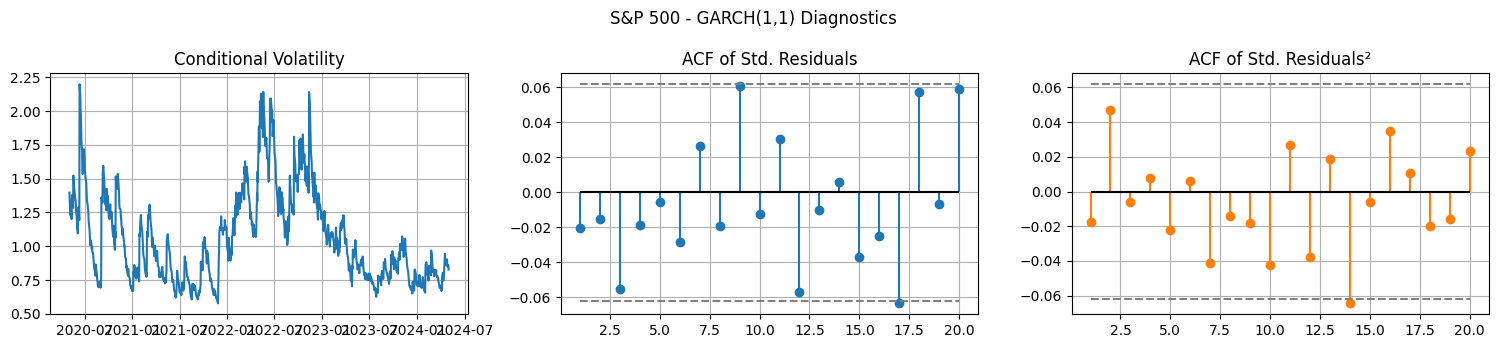


--- GARCH(2,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1426.22
Distribution:      Standardized Student's t   AIC:                           2864.44
Method:                  Maximum Likelihood   BIC:                           2893.91
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:03:34   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

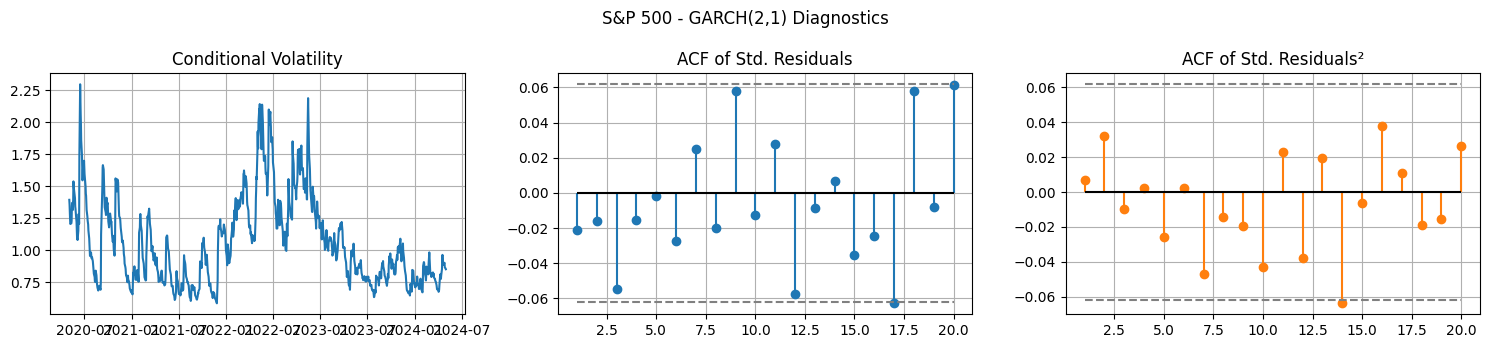


--- GARCH(1,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1426.98
Distribution:      Standardized Student's t   AIC:                           2865.96
Method:                  Maximum Likelihood   BIC:                           2895.43
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:03:35   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

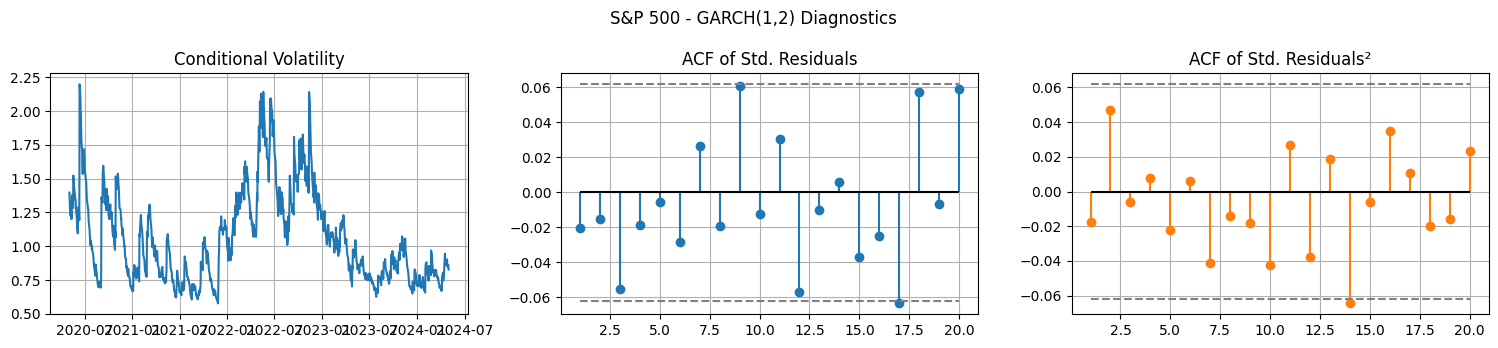


--- GARCH(2,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1425.97
Distribution:      Standardized Student's t   AIC:                           2865.94
Method:                  Maximum Likelihood   BIC:                           2900.33
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:03:36   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

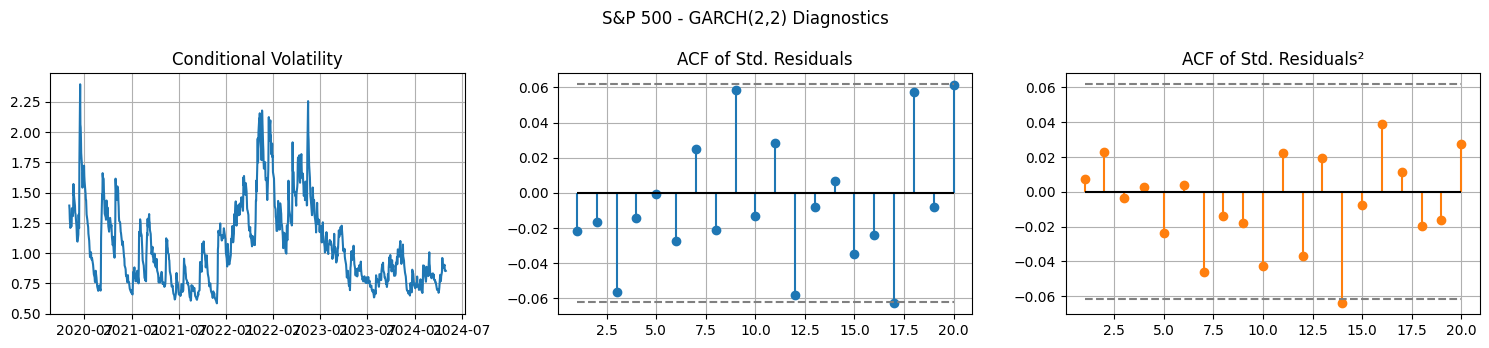


Best model for S&P 500 is GARCH(1,1) (AIC = 2863.96)


{'Model': 'GARCH(1,1)',
 'AIC': 2863.9574680262485,
 'BIC': 2888.5211821287144,
 'LB_resid_p': {5: 0.5332341137215522,
  10: 0.4475956569813382,
  15: 0.4042630548739195,
  20: 0.12386410605935147},
 'LB_sqres_p': {5: 0.676606414088706,
  10: 0.6981477696433678,
  15: 0.5166395376011227,
  20: 0.6743416992615154},
 'ARCH_pval': 0.6952136945184295,
 'res':                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                        Close   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -1426.98
 Distribution:      Standardized Student's t   AIC:                           2863.96
 Method:                  Maximum Likelihood   BIC:                           2888.52
                                               No. Observations:                 1005
 Date:                      mer, giu 04 2

In [21]:
analyze_garch_for_asset(gspc_train, name='S&P 500')

Best model for S&P 500 is GARCH(1,1) (AIC = 2863.96);

#### Let's check manually the model - GARCH(1,1)


In [22]:
gspc_garch11 = arch_model(y = 100*np.log(gspc_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 't')
gspc_garch11_result = gspc_garch11.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6015.303707233424
Iteration:      2,   Func. Count:     17,   Neg. LLF: 64161.573605089725
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1432.6263723660531
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1810.8695495886561
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1429.4974661890192
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1432.2849745046224
Iteration:      7,   Func. Count:     56,   Neg. LLF: 1426.982750075988
Iteration:      8,   Func. Count:     62,   Neg. LLF: 1426.980736209853
Iteration:      9,   Func. Count:     68,   Neg. LLF: 1426.9793347534908
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1426.9790051622185
Iteration:     11,   Func. Count:     80,   Neg. LLF: 1426.978743280939
Iteration:     12,   Func. Count:     86,   Neg. LLF: 1426.9787340131243
Iteration:     13,   Func. Count:     91,   Neg. LLF: 1426.9787340131243
Optimization terminated successfully    (Exit mode 0)
 

In [23]:
print(gspc_garch11_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1426.98
Distribution:      Standardized Student's t   AIC:                           2863.96
Method:                  Maximum Likelihood   BIC:                           2888.52
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:04:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### GARCH(1,1) Model for GSPC

The **GARCH(1,1)** model was estimated for the GSPC asset.

$$
\sigma_t^2 = \omega + \alpha_1 u_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

**Parameter Interpretation**:
- $( \mu = 0.1040 $) (significant, positive mean return),
- $( \omega = 0.0226 $) (baseline variance),
- $( \alpha_1 = 0.0928 $) (reaction to past shocks),
- $( \beta_1 = 0.8901 $) (persistence of volatility),
- $( \alpha_1 + \beta_1 = 0.9829 $) (stationarity condition satisfied).
- $( \nu = 8.8191)$ (presence of fat tails)

 
**Diagnostics**:

The model has passed autocorrelation and ARCH effects tests on standardized residuals.

**News Impact Curve**

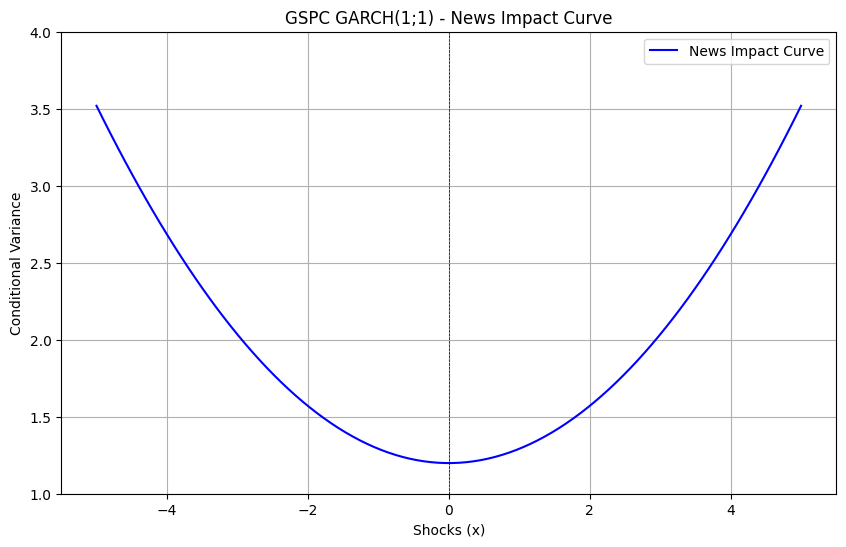

In [24]:
# Parameters for the GARCH model 

 
# Function to compute the news impact curve 
def news_impact_curve(shocks, omega, alpha, beta): 
    variances = omega + alpha * shocks**2 + beta * (omega / (1 - alpha - beta))  # Steady-state variance 
    return variances 
 
# Generate shock values 
shocks = np.linspace(-5, 5, 100) 
 
# Calculate the news impact curve 
gspc_garch11_nic = news_impact_curve(shocks, 0.0226, 0.0928, 0.8901) 
 
# Plotting the news impact curve 
plt.figure(figsize=(10, 6)) 
plt.plot(shocks, gspc_garch11_nic, label='News Impact Curve', color='blue') 
plt.title('GSPC GARCH(1;1) - News Impact Curve') 
plt.xlabel('Shocks (x)') 
plt.ylabel('Conditional Variance') 
plt.axhline(0, color='black', lw=0.5, ls='--') 
plt.axvline(0, color='black', lw=0.5, ls='--') 
plt.ylim(bottom = 1, top = 4)
plt.grid() 
plt.legend() 
plt.show() 

It shows the impact of shocks on the estimated conditional volatility, with the curve's shape indicating that both positive and negative shocks lead to an increase in volatility. As we know, the GARCH model does not account for the leverage effect: the relationship between volatility and shocks is modeled symmetrically.

**Conditional Volatility**

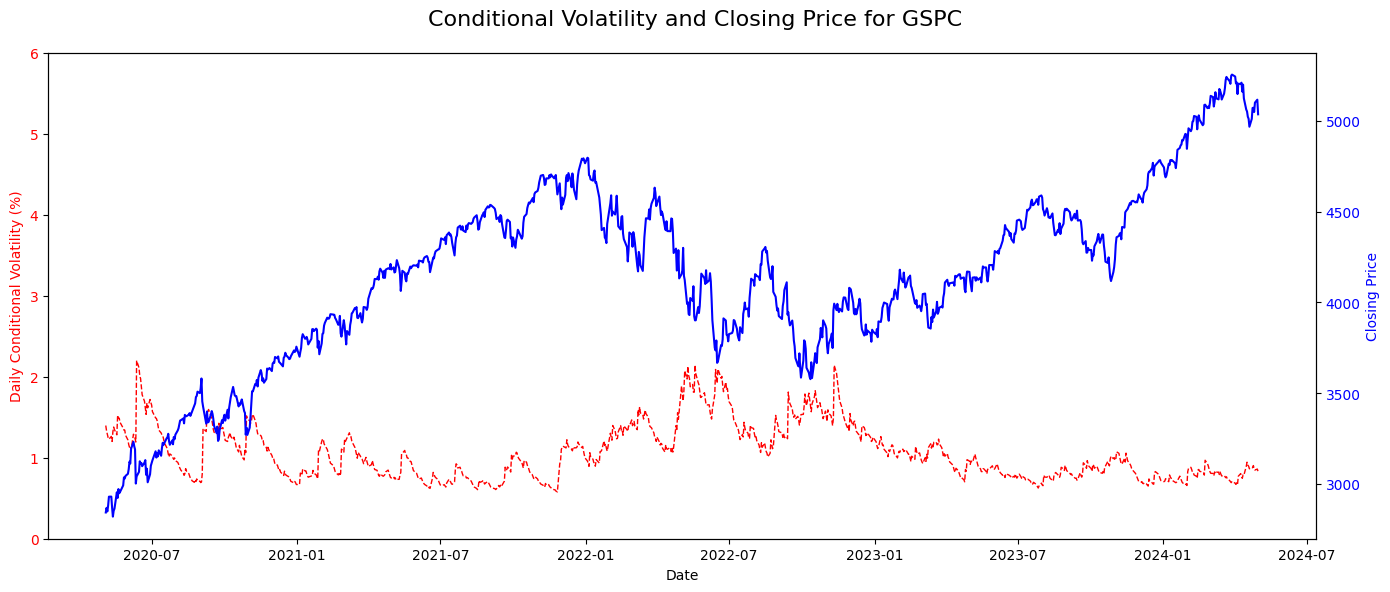

In [25]:
gspc_garch11_condvol = gspc_garch11_result.conditional_volatility

# Plotting Conditional Volatility and Closing Price
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Conditional Volatility (red line)
ax1.plot(gspc_garch11_condvol.index, gspc_garch11_condvol, color='red', linestyle='--', label='Conditional Volatility (σ)', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylim(bottom=0, top=6)
ax1.set_ylabel('Daily Conditional Volatility (%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for the Closing Price
ax2 = ax1.twinx()
ax2.plot(gspc_train['Close'].loc[gspc_garch11_condvol.index].index, gspc_train['Close'].loc[gspc_garch11_condvol.index], color='blue', label='Closing Price', linewidth=1.5)
ax2.set_ylabel('Closing Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legend
fig.suptitle('Conditional Volatility and Closing Price for GSPC', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()






This plot displays the conditional volatility (also known as the conditional standard deviation) estimated by the model. It shows significant spikes during periods of market turmoil, responding to new shocks in prices (and consequently in log-returns). The persistence of volatility is evident, as clusters of high (or low) volatility follow periods of elevated (or diminished) volatility.

## 1.2 Boeing


=== GARCH Model Estimation & Diagnostics for BOEING ===

--- GARCH(1,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2299.50
Distribution:      Standardized Student's t   AIC:                           4609.01
Method:                  Maximum Likelihood   BIC:                           4633.57
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:06:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------

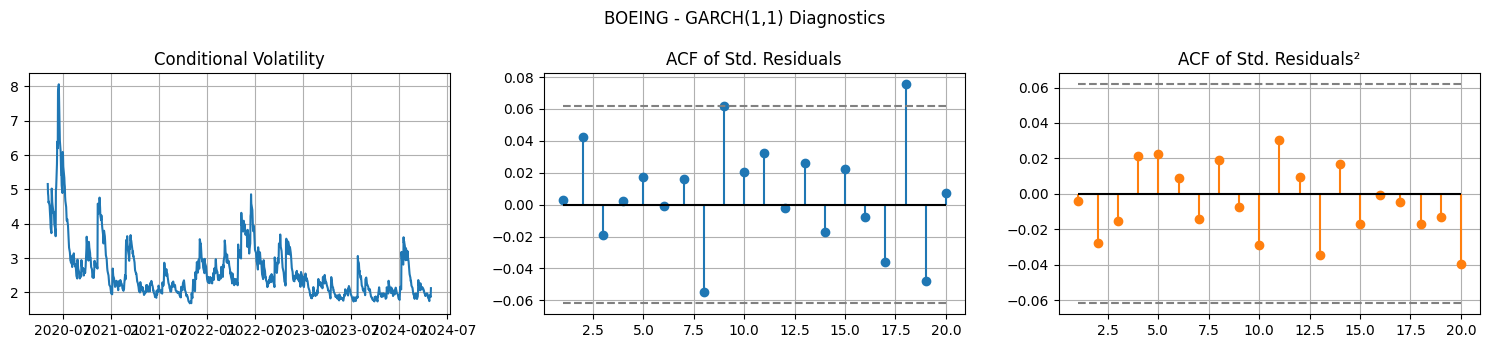


--- GARCH(2,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2299.50
Distribution:      Standardized Student's t   AIC:                           4611.01
Method:                  Maximum Likelihood   BIC:                           4640.48
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:06:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

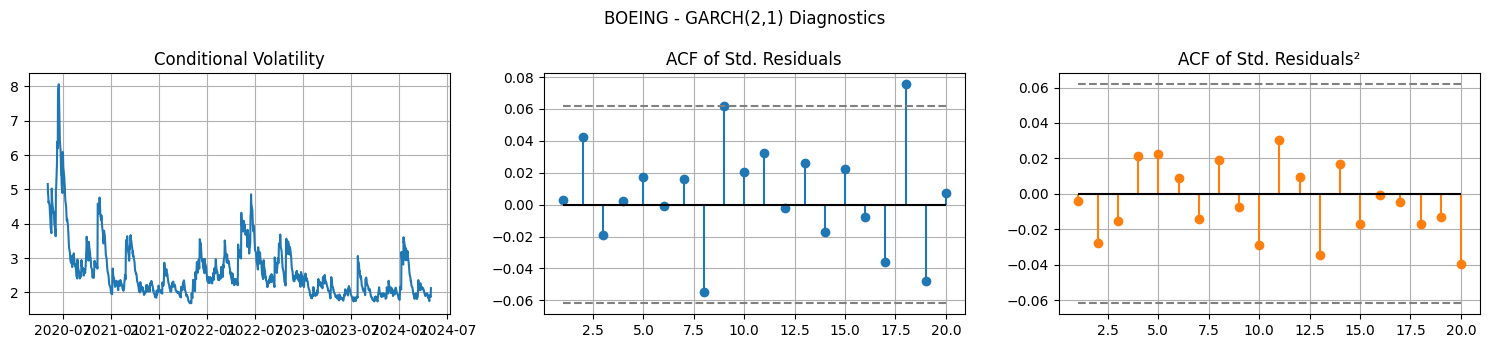


--- GARCH(1,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2299.01
Distribution:      Standardized Student's t   AIC:                           4610.02
Method:                  Maximum Likelihood   BIC:                           4639.50
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:06:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

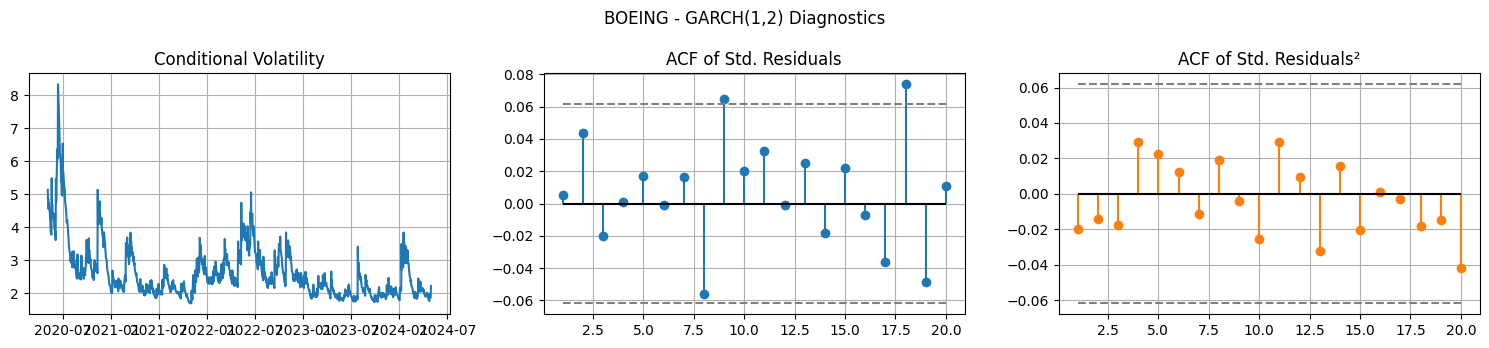


--- GARCH(2,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2299.01
Distribution:      Standardized Student's t   AIC:                           4612.02
Method:                  Maximum Likelihood   BIC:                           4646.41
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:06:12   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

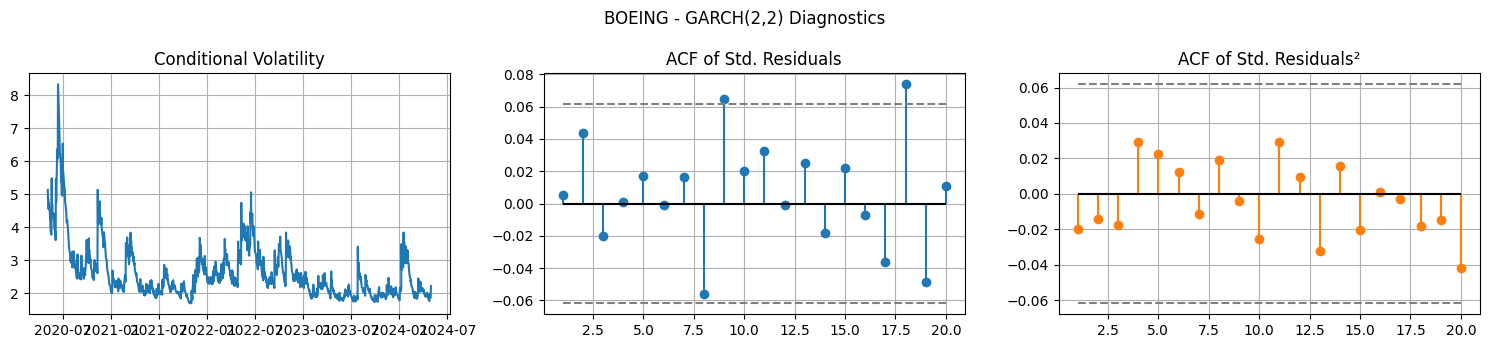


Best model for BOEING is GARCH(1,1) (AIC = 4609.01)


{'Model': 'GARCH(1,1)',
 'AIC': 4609.005081816729,
 'BIC': 4633.5687959191955,
 'LB_resid_p': {5: 0.7732217514852757,
  10: 0.4286078563975019,
  15: 0.6277794998667329,
  20: 0.32332591560146},
 'LB_sqres_p': {5: 0.8512235179329821,
  10: 0.9657721079867806,
  15: 0.9733057552785689,
  20: 0.988437844794628},
 'ARCH_pval': 0.860286111604057,
 'res':                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                        Close   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -2299.50
 Distribution:      Standardized Student's t   AIC:                           4609.01
 Method:                  Maximum Likelihood   BIC:                           4633.57
                                               No. Observations:                 1005
 Date:                      mer, giu 04 2025  

In [26]:
analyze_garch_for_asset(ba_train, name='Boeing')

#### Manually check - GARCH(1,1)

In [27]:
ba_garch11 = arch_model(y = 100*np.log(ba_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 't')
ba_garch11_result = ba_garch11.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 38678.11926233952
Iteration:      2,   Func. Count:     15,   Neg. LLF: 130583.4990506614
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2640.5022350568615
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3481.8022571297797
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3137.3408826407876
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3150.3780629508283
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2306.2692829504417
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2299.765829280401
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2299.6368002742147
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2299.5396078089598
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2299.514951882613
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2299.5093954106137
Iteration:     13,   Func. Count:     91,   Neg. LLF: 2299.5031782684764
Iteration:     14,   Func. Count:     97,   Neg. LLF: 2

In [28]:
print(ba_garch11_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2299.50
Distribution:      Standardized Student's t   AIC:                           4609.01
Method:                  Maximum Likelihood   BIC:                           4633.57
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:06:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

Again, the best model for BOEING is GARCH(1,1):

$$
\sigma_t^2 = \omega + \alpha_1 u_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

**Parameter Interpretation**:
- $( \mu = -0.0339 $) (not significantly different from zero),
- $( \omega = 0.2487 $) (not significant, baseline variance),
- $( \alpha_1 = 0.0867 $) (reaction to past shocks),
- $( \beta_1 = 0.8802 $) (persistence of volatility),
- $( \alpha_1 + \beta_1 < 1 $) (stationarity condition satisfied).
- $( \nu = 4.7052)$ (presence of fat tails)

**Diagnostics**:

The model has passed autocorrelation and ARCH effects tests on standardized residuals.

**News Impact Curve**

We will expect the NIC to be identical to the previous one plotted for GSPC.

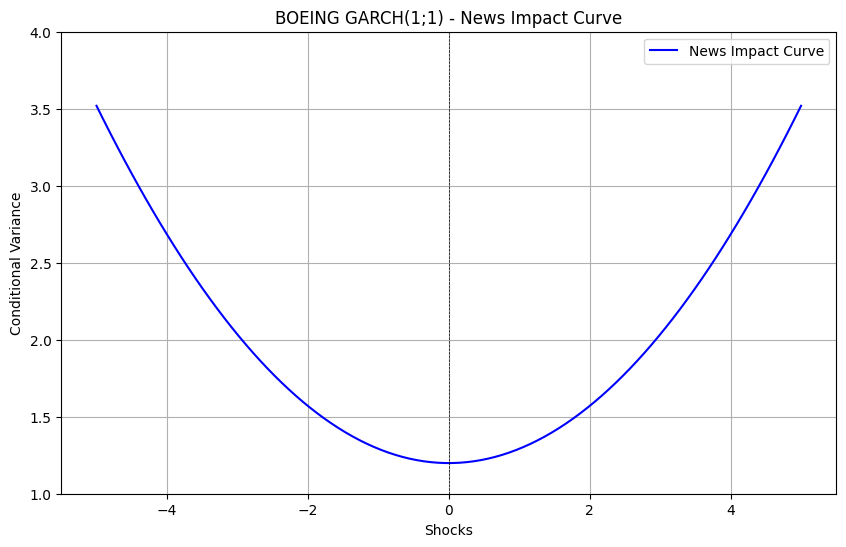

In [29]:
# Calculate the news impact curve 
ba_garch11_nic = news_impact_curve(shocks, 0.2487, 0.0867, 0.8802) 
 
# Generate shock values 
shocks = np.linspace(-5, 5, 100) 
 
# Calculate the news impact curve 
ba_garch11_nic = news_impact_curve(shocks, 0.0226, 0.0928, 0.8901) 
 
# Plotting the news impact curve 
plt.figure(figsize=(10, 6)) 
plt.plot(shocks, ba_garch11_nic, label='News Impact Curve', color='blue') 
plt.title('BOEING GARCH(1;1) - News Impact Curve') 
plt.xlabel('Shocks') 
plt.ylabel('Conditional Variance') 
plt.axhline(0, color='black', lw=0.5, ls='--') 
plt.axvline(0, color='black', lw=0.5, ls='--') 
plt.ylim(bottom = 1, top = 4)
plt.grid() 
plt.legend() 
plt.show() 

**Conditional Volatility**

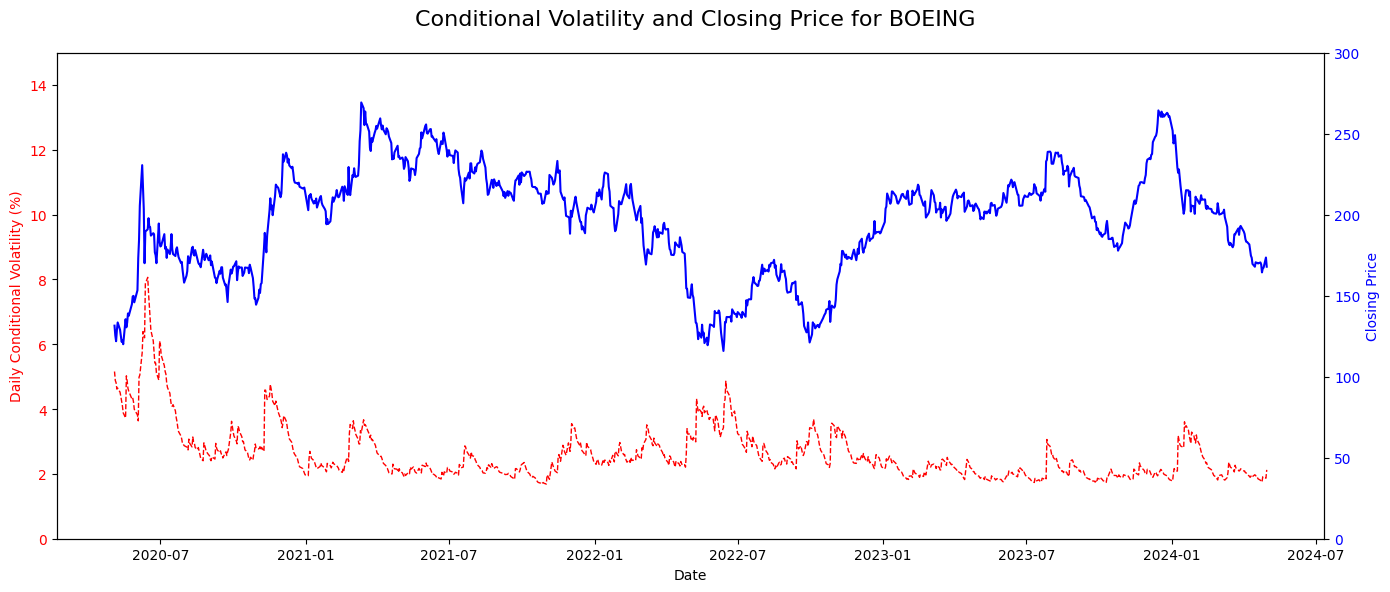

In [ ]:
ba_garch11_condvol = ba_garch11_result.conditional_volatility

# Plotting Conditional Volatility and Closing Price
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Conditional Volatility (red line)
ax1.plot(ba_garch11_condvol.index, ba_garch11_condvol, color='red', linestyle='--', label='Conditional Volatility (σ)', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylim(bottom=0, top=15)
ax1.set_ylabel('Daily Conditional Volatility (%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for the Closing Price
ax2 = ax1.twinx()
ax2.plot(ba_train['Close'].loc[ba_garch11_condvol.index].index, ba_train['Close'].loc[ba_garch11_condvol.index], color='blue', label='Closing Price', linewidth=1.5)
ax2.set_ylim(bottom=0, top=300)
ax2.set_ylabel('Closing Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legend
fig.suptitle('Conditional Volatility and Closing Price for BOEING', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()


## 1.3 ETH


=== GARCH Model Estimation & Diagnostics for ETHEREUM ===

--- GARCH(1,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2941.99
Distribution:      Standardized Student's t   AIC:                           5893.99
Method:                  Maximum Likelihood   BIC:                           5918.55
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:07:13   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
----

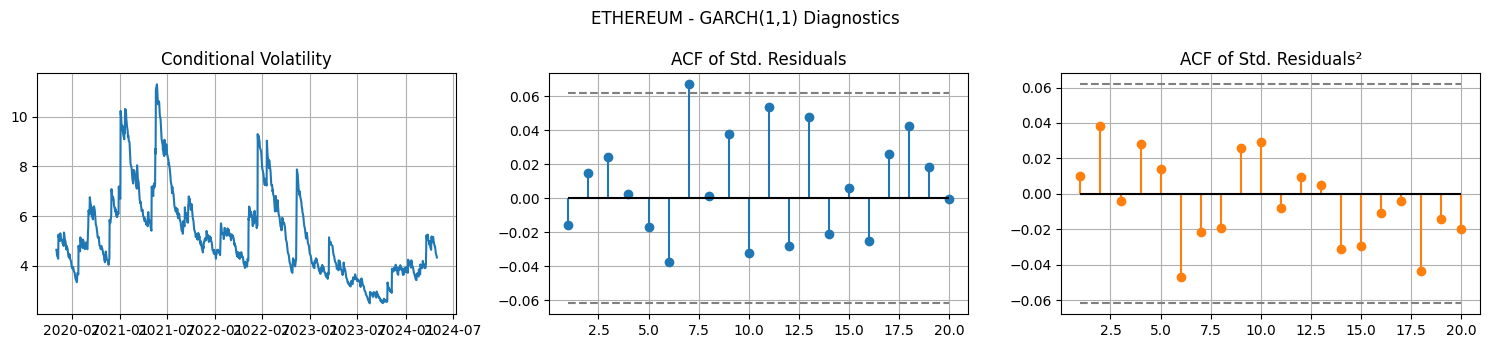


--- GARCH(2,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2941.93
Distribution:      Standardized Student's t   AIC:                           5895.85
Method:                  Maximum Likelihood   BIC:                           5925.33
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:07:14   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------

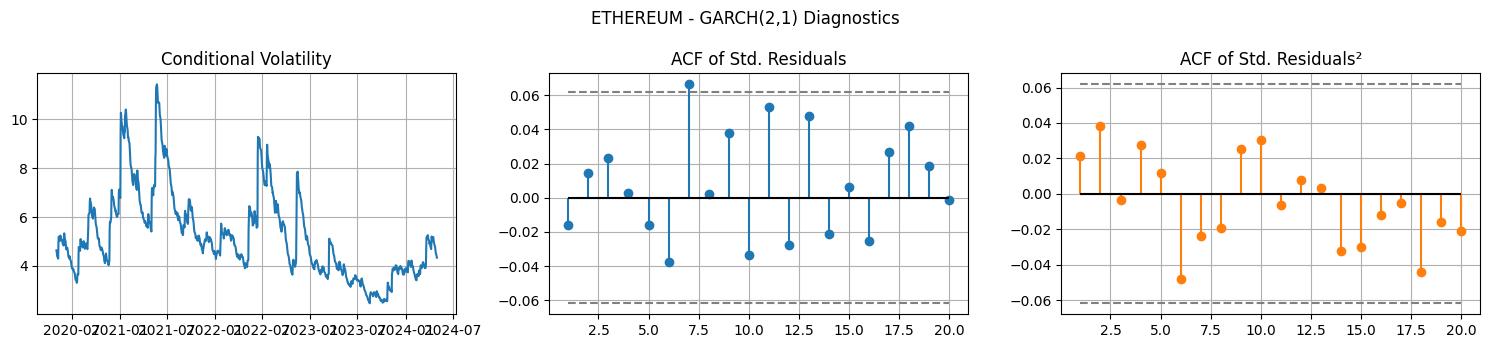


--- GARCH(1,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2941.99
Distribution:      Standardized Student's t   AIC:                           5895.99
Method:                  Maximum Likelihood   BIC:                           5925.46
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:07:15   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------

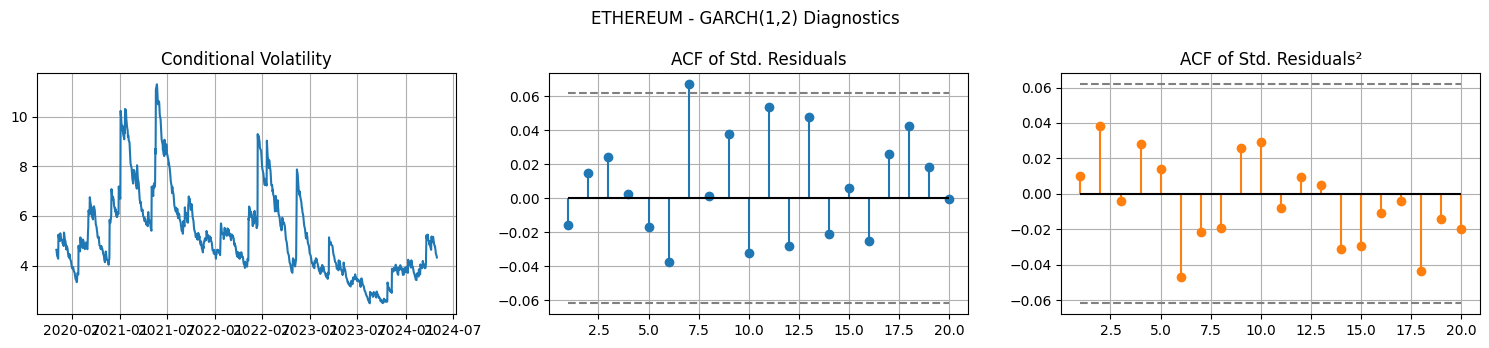


--- GARCH(2,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2941.68
Distribution:      Standardized Student's t   AIC:                           5897.37
Method:                  Maximum Likelihood   BIC:                           5931.76
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:07:16   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------

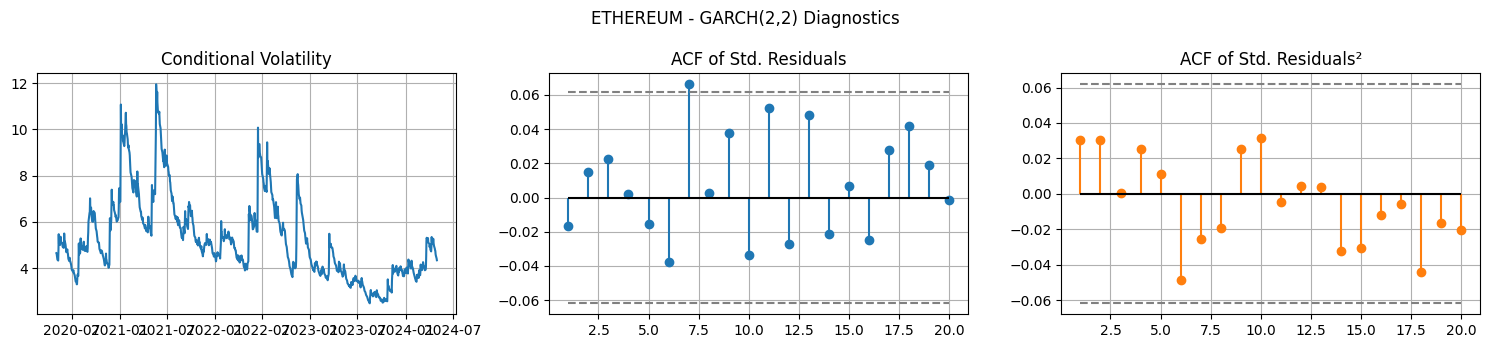


Best model for ETHEREUM is GARCH(1,1) (AIC = 5893.99)


{'Model': 'GARCH(1,1)',
 'AIC': 5893.986568666594,
 'BIC': 5918.550282769061,
 'LB_resid_p': {5: 0.9282981166399262,
  10: 0.4481683806963501,
  15: 0.3489843352549461,
  20: 0.4558215839087401},
 'LB_sqres_p': {5: 0.7592360818466084,
  10: 0.7030120320621002,
  15: 0.8607250351499489,
  20: 0.9152870791823763},
 'ARCH_pval': 0.7793825831948173,
 'res':                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                        Close   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -2941.99
 Distribution:      Standardized Student's t   AIC:                           5893.99
 Method:                  Maximum Likelihood   BIC:                           5918.55
                                               No. Observations:                 1005
 Date:                      mer, giu 04 202

In [31]:
analyze_garch_for_asset(eth_train, name='Ethereum')

#### Manually chack - **GARCH(1,1)**

In [33]:
eth_garch11 = arch_model(y = 100*np.log(eth_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 't')
eth_garch11_result = eth_garch11.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5210.223078489296
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3868.5152465662522
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3834.747476258962
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3156.088323932093
Iteration:      5,   Func. Count:     36,   Neg. LLF: 3705.8090189508807
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2951.8864561248265
Iteration:      7,   Func. Count:     50,   Neg. LLF: 3000.769407157464
Iteration:      8,   Func. Count:     57,   Neg. LLF: 2944.890133615042
Iteration:      9,   Func. Count:     64,   Neg. LLF: 2942.033243315118
Iteration:     10,   Func. Count:     70,   Neg. LLF: 2942.8396117928264
Iteration:     11,   Func. Count:     77,   Neg. LLF: 2942.426353205291
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2941.995276352396
Iteration:     13,   Func. Count:     91,   Neg. LLF: 2941.9934009196854
Iteration:     14,   Func. Count:     98,   Neg. LLF: 2941.

In [34]:
print(eth_garch11_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2941.99
Distribution:      Standardized Student's t   AIC:                           5893.99
Method:                  Maximum Likelihood   BIC:                           5918.55
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:08:43   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

The GARCH(1;1) is the best model for 'ETH' as well:

$$
\sigma_t^2 = \omega + \alpha_1 u_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

**Parameter Interpretation**:
- $( \mu = 0.1577 $) (not significantly different from zero),
- $( \omega = 0.1521 $) (not significantly different from zero),
- $( \alpha_1 = 0.0532 $) (reaction to past shocks),
- $( \beta_1 = 0.9468 $) (persistence of volatility),
- $( \alpha_1 + \beta_1 = 1 $) (*STATIONARITY CONDITION NOT SATISFIED*).
- $( \nu = 3.7485)$ (presence of fat tails)

Even if this GARCH(1;1) seems to be the best model for 'ETH', there is a substantial problem with it -> $\alpha_1+\beta_1 = 1$: it means that the volatility estimated by the model does not tend to revent to a long term mean, leading to a persistence of shocks that does not decay over time. 

In practice, this means that the model does not fully capture the idea of volatility clustering, since periods oh high volatility are likely to persist indefinitely unless the shock decays.

Let's take a look at the plot of the conditional volatility:

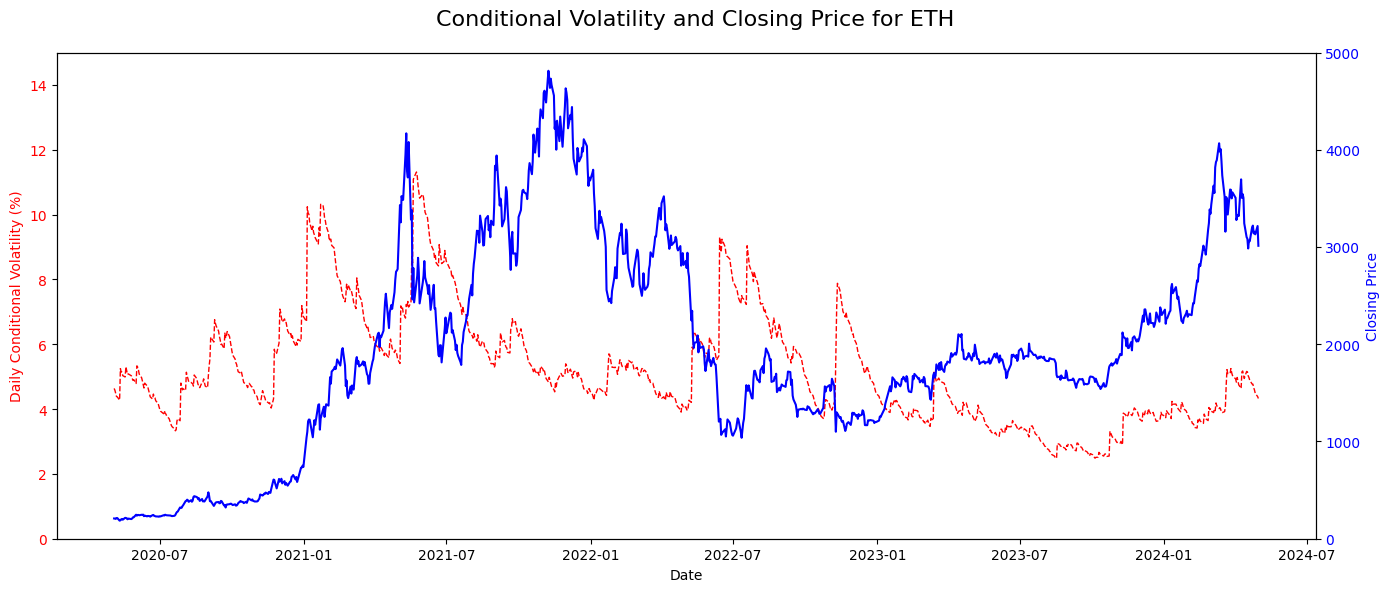

In [36]:
eth_garch11_condvol = eth_garch11_result.conditional_volatility

# Plotting Conditional Volatility and Closing Price
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Conditional Volatility (red line)
ax1.plot(eth_garch11_condvol.index, eth_garch11_condvol, color='red', linestyle='--', label='Conditional Volatility (σ)', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylim(bottom=0, top=15)
ax1.set_ylabel('Daily Conditional Volatility (%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for the Closing Price
ax2 = ax1.twinx()
ax2.plot(eth_train['Close'].loc[eth_garch11_condvol.index].index, eth_train['Close'].loc[eth_garch11_condvol.index], color='blue', label='Closing Price', linewidth=1.5)
ax2.set_ylim(bottom=0, top=5000)
ax2.set_ylabel('Closing Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legend
fig.suptitle('Conditional Volatility and Closing Price for ETH', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()

Later, we will explore extensions of the GARCH model to address this issue and better capture the volatility dynamics.

## 1.4 USD-PLN


=== GARCH Model Estimation & Diagnostics for USD-PLN ===

--- GARCH(1,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1053.16
Distribution:      Standardized Student's t   AIC:                           2116.31
Method:                  Maximum Likelihood   BIC:                           2140.88
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:09:21   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.

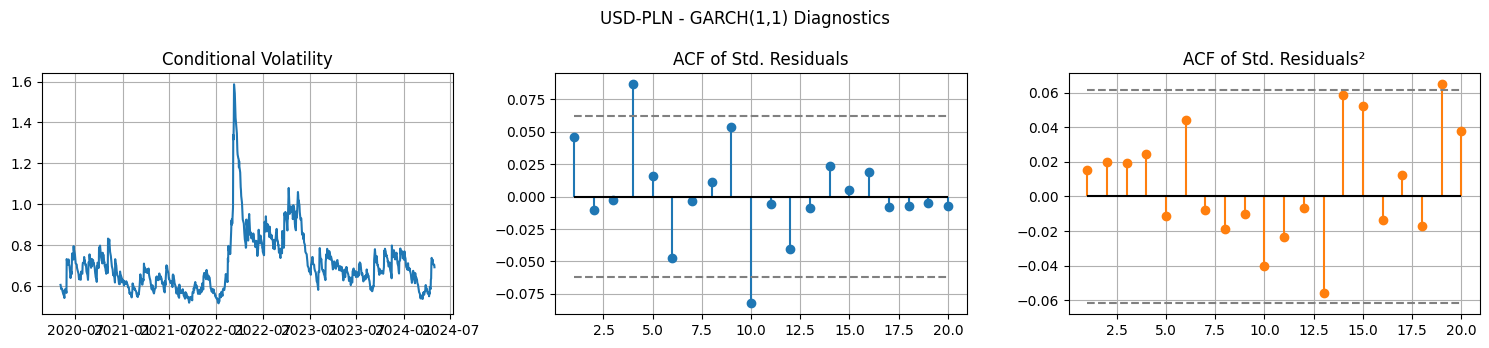


--- GARCH(2,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1053.16
Distribution:      Standardized Student's t   AIC:                           2118.31
Method:                  Maximum Likelihood   BIC:                           2147.79
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:09:22   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

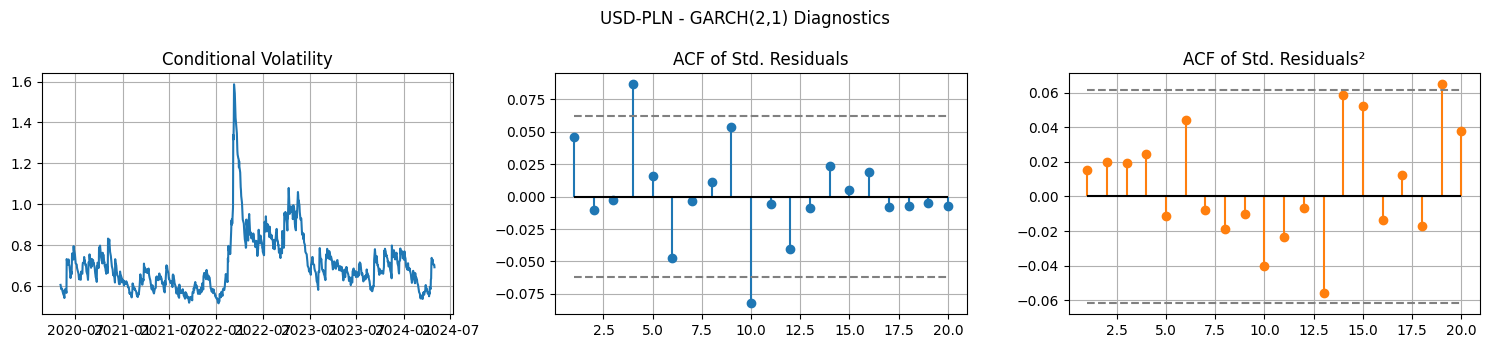


--- GARCH(1,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1053.13
Distribution:      Standardized Student's t   AIC:                           2118.27
Method:                  Maximum Likelihood   BIC:                           2147.75
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:09:23   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

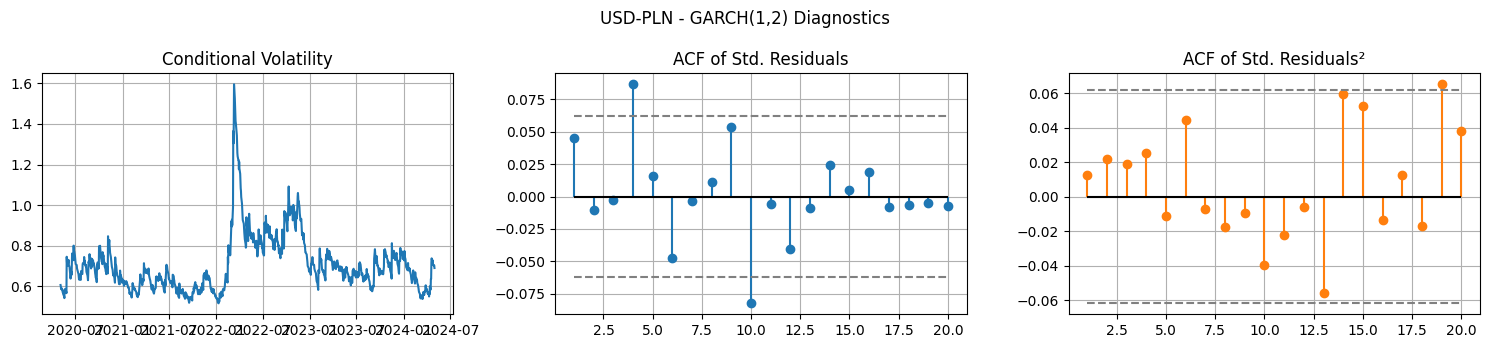


--- GARCH(2,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1053.03
Distribution:      Standardized Student's t   AIC:                           2120.06
Method:                  Maximum Likelihood   BIC:                           2154.45
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:09:24   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

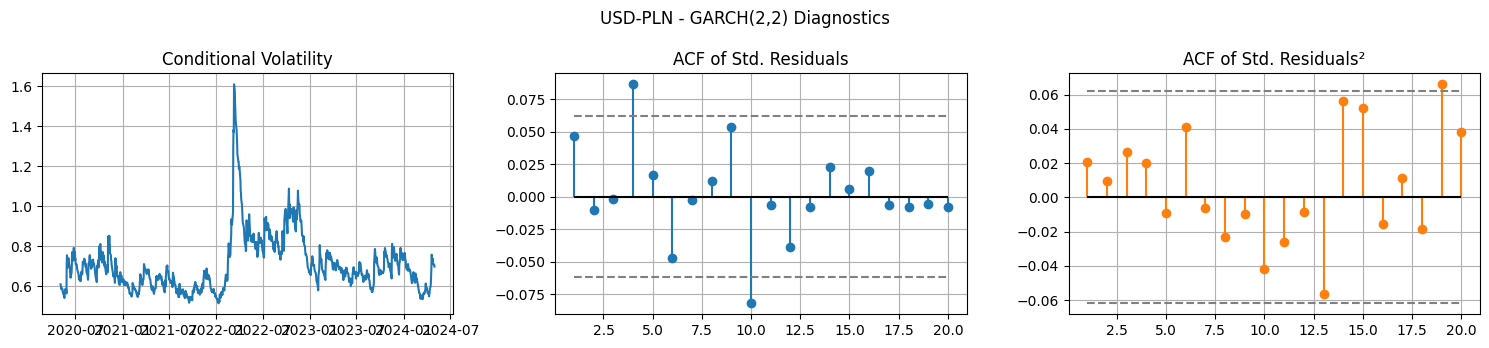


No model passed all diagnostics. Best by AIC for USD-PLN is GARCH(1,1) (AIC = 2116.31)


{'Model': 'GARCH(1,1)',
 'AIC': 2116.3114214307743,
 'BIC': 2140.87513553324,
 'LB_resid_p': {5: 0.07330521852434019,
  10: 0.013790904007121813,
  15: 0.05518706953530956,
  20: 0.1940929272133895},
 'LB_sqres_p': {5: 0.8821030775180002,
  10: 0.8230282982263234,
  15: 0.37882946690771346,
  20: 0.31440161484153845},
 'ARCH_pval': 0.8932733178594621,
 'res':                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                        Close   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -1053.16
 Distribution:      Standardized Student's t   AIC:                           2116.31
 Method:                  Maximum Likelihood   BIC:                           2140.88
                                               No. Observations:                 1005
 Date:                      mer, giu 

In [37]:
analyze_garch_for_asset(usdpln_train, name='USD-PLN')

#### Manually check - **GARCH(1,1)**

*WARNING*: Even if the best model by AIC for USD-PLN is GARCH(1,1), no model passed all of the diagnostics.  The latter failed the LB test (only at lag 10) for autocorrelation of the standardized residuals.

In [38]:
usdpln_garch11 = arch_model(y = 100*np.log(usdpln_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 't')
usdpln_garch11_result = usdpln_garch11.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4778.21266769961
Iteration:      2,   Func. Count:     18,   Neg. LLF: 118115.65425059429
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1086.3574250685338
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1473.7919651849215
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1054.7402231144354
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1053.1609978709726
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1053.159733023354
Iteration:      8,   Func. Count:     65,   Neg. LLF: 1053.157215427447
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1053.1560392828756
Iteration:     10,   Func. Count:     77,   Neg. LLF: 1053.1557331618233
Iteration:     11,   Func. Count:     83,   Neg. LLF: 1053.1557107153872
Iteration:     12,   Func. Count:     88,   Neg. LLF: 1053.155710715387
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1053.1557107153872
            Iteratio

In [39]:
print(usdpln_garch11_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1053.16
Distribution:      Standardized Student's t   AIC:                           2116.31
Method:                  Maximum Likelihood   BIC:                           2140.88
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:10:06   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Let's take a proper look at the ACF of the residuals:

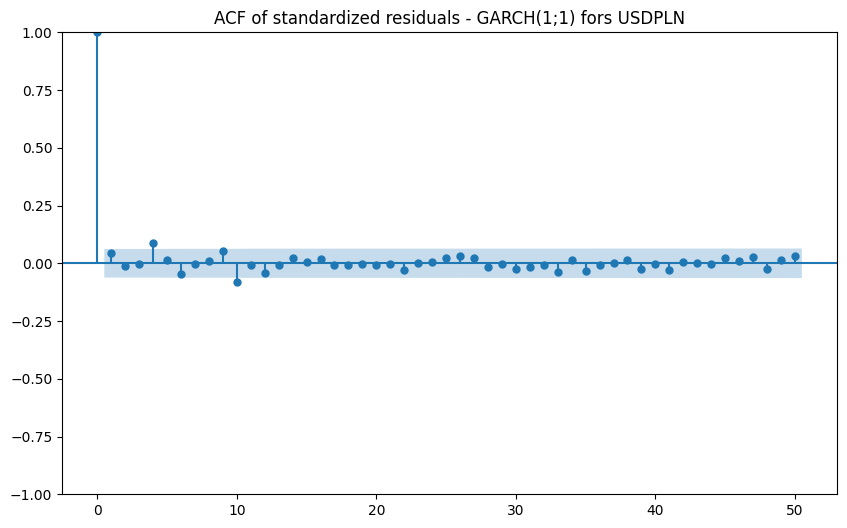

In [40]:
usdpln_garch11_std_res = usdpln_garch11_result.std_resid

fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(usdpln_garch11_std_res, lags=50, ax=ax)
plt.title('ACF of standardized residuals - GARCH(1;1) fors USDPLN')
plt.show()

Although the model fails the Ljung-Box (LB) test at lag 10, this may not be a significant issue, especially considering the ACF shows no major autocorrelations beyond 50 lags. Given this, we will base our decision on exploring new GARCH extensions to better capture the volatility dynamics of this asset.

At the moment let's take a look at the conditional volatility:

**Conditional Volatility**

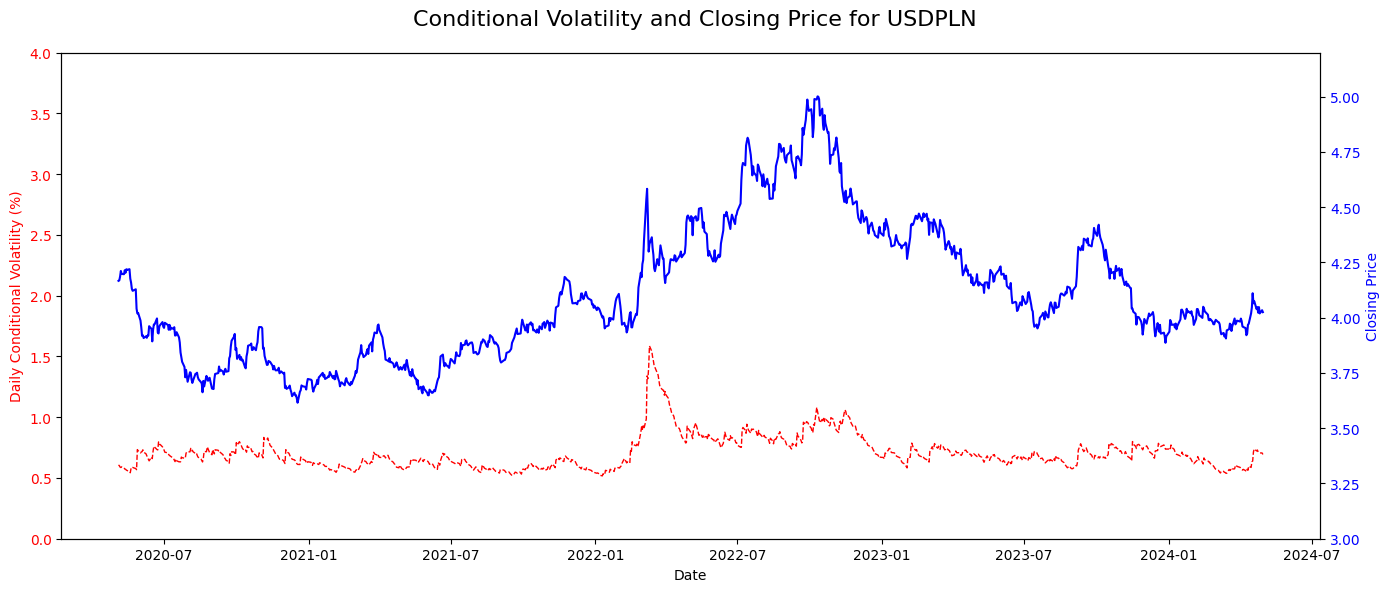

In [41]:
usdpln_garch11_condvol = usdpln_garch11_result.conditional_volatility

# Plotting Conditional Volatility and Closing Price
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Conditional Volatility (red line)
ax1.plot(usdpln_garch11_condvol.index, usdpln_garch11_condvol, color='red', linestyle='--', label='Conditional Volatility (σ)', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylim(bottom=0, top=4)
ax1.set_ylabel('Daily Conditional Volatility (%)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for the Closing Price
ax2 = ax1.twinx()
ax2.plot(eth_train['Close'].loc[usdpln_garch11_condvol.index].index, usdpln_train['Close'].loc[usdpln_garch11_condvol.index], color='blue', label='Closing Price', linewidth=1.5)
ax2.set_ylim(bottom=3, top=5.2)
ax2.set_ylabel('Closing Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and legend
fig.suptitle('Conditional Volatility and Closing Price for USDPLN', fontsize=16)
fig.tight_layout()

# Show the plot
plt.show()






## 1.5 Gold


=== GARCH Model Estimation & Diagnostics for GOLD ===

--- GARCH(1,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1329.05
Distribution:      Standardized Student's t   AIC:                           2668.09
Method:                  Maximum Likelihood   BIC:                           2692.66
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:10:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------

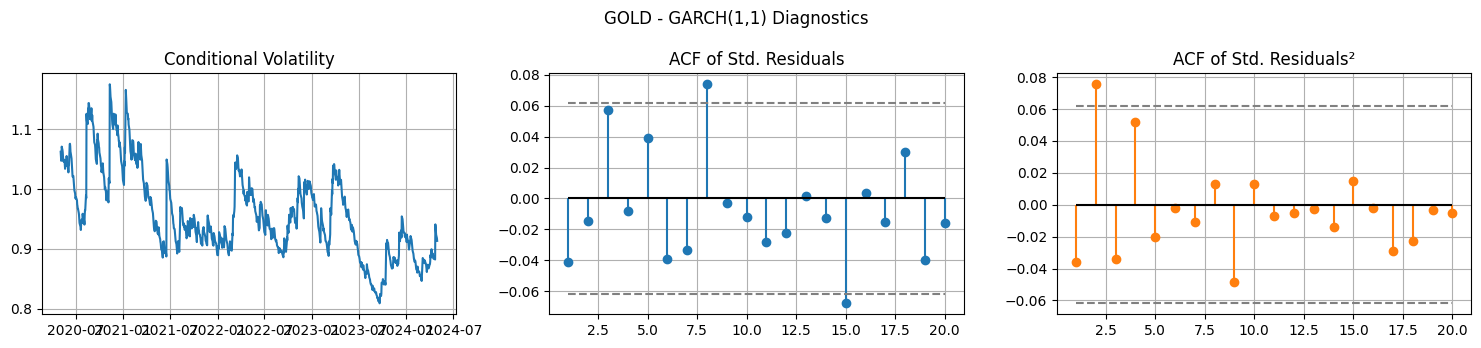


--- GARCH(2,1) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1329.47
Distribution:      Standardized Student's t   AIC:                           2670.94
Method:                  Maximum Likelihood   BIC:                           2700.41
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:10:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

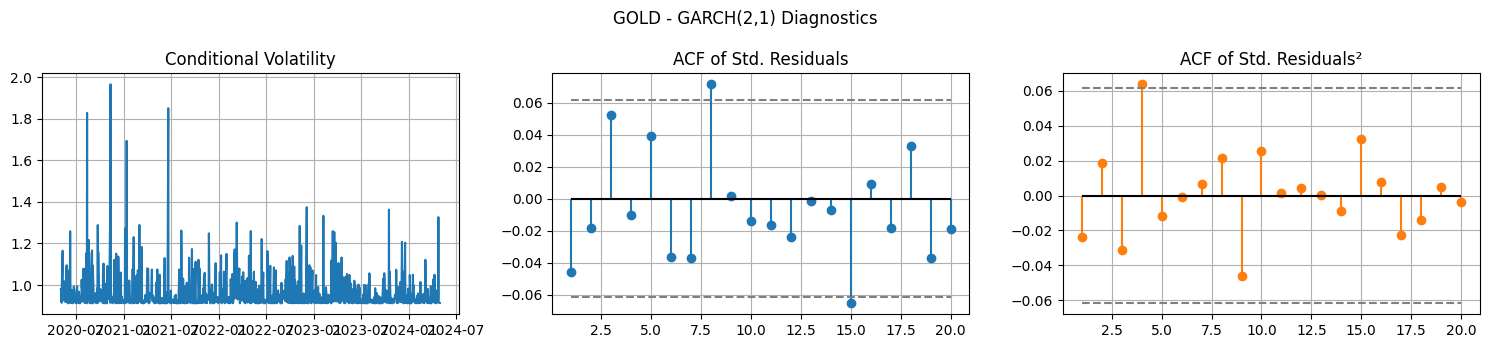


--- GARCH(1,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1329.05
Distribution:      Standardized Student's t   AIC:                           2670.09
Method:                  Maximum Likelihood   BIC:                           2699.57
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:10:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

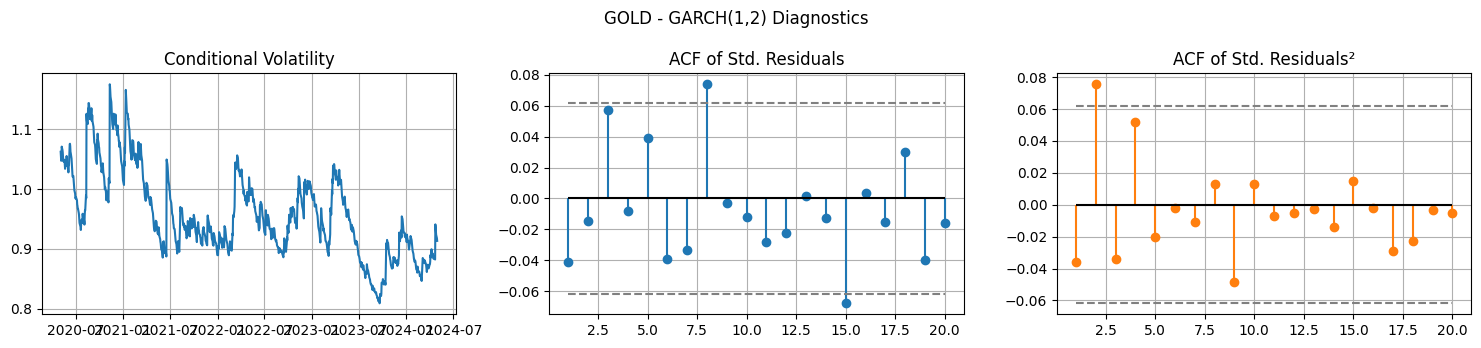


--- GARCH(2,2) ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1326.82
Distribution:      Standardized Student's t   AIC:                           2667.63
Method:                  Maximum Likelihood   BIC:                           2702.02
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:10:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------------------

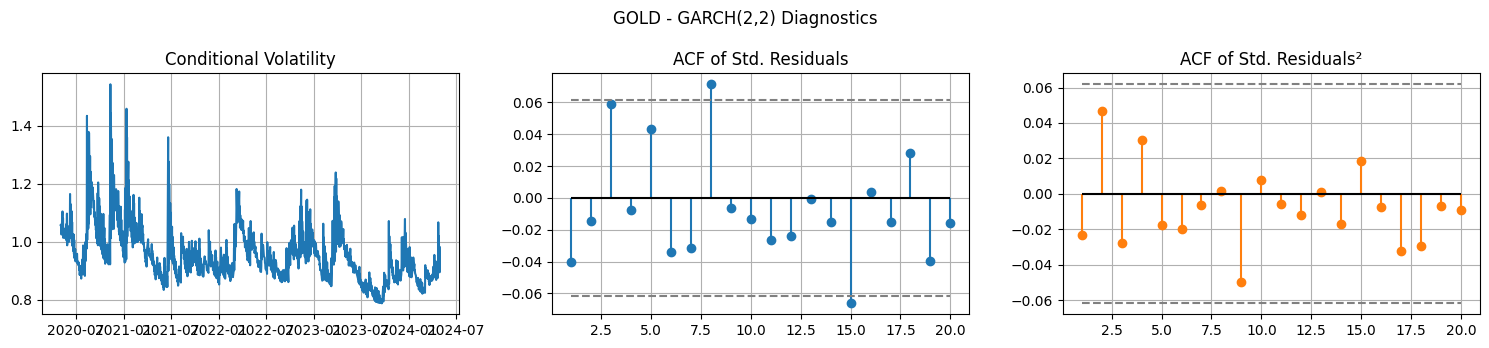


Best model for GOLD is GARCH(2,2) (AIC = 2667.63)


{'Model': 'GARCH(2,2)',
 'AIC': 2667.633730410992,
 'BIC': 2702.022930154444,
 'LB_resid_p': {5: 0.19545504947530293,
  10: 0.13502317326203173,
  15: 0.1383581003514167,
  20: 0.24689384956816884},
 'LB_sqres_p': {5: 0.4401262059916098,
  10: 0.6456317648882652,
  15: 0.8950230028144514,
  20: 0.9515589568828043},
 'ARCH_pval': 0.4939116313180332,
 'res':                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                        Close   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -1326.82
 Distribution:      Standardized Student's t   AIC:                           2667.63
 Method:                  Maximum Likelihood   BIC:                           2702.02
                                               No. Observations:                 1005
 Date:                      mer, giu 04 

In [42]:
analyze_garch_for_asset(gold_train, name='Gold')

### Manual check - GARCH(1,1) & GARCH(2,2)
The best model for GOLD is GARCH(2,2) (AIC = 2667.63), let's see if the differences with a simpler GARCH(1;1) is enough to justify 2 more parameters:

In [44]:
#Garch(1,1)
gold_garch11 = arch_model(y = 100*np.log(gold_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 't')
gold_garch11_result = gold_garch11.fit()

# GARCH(2,2)
gold_garch22 = arch_model(y = 100*np.log(gold_train['Close']).diff().dropna(), mean = 'constant', vol = 'GARCH', p = 2, q = 2, dist = 't')
gold_garch22_result = gold_garch22.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 48386.806292252644
Iteration:      2,   Func. Count:     16,   Neg. LLF: 43420.7944573906
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3616.1479436276304
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2142.697800222386
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2207.149974104872
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1972.281008645675
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1329.2869401798548
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1338.130206246647
Iteration:      9,   Func. Count:     69,   Neg. LLF: 1329.3418013126718
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1329.050707240734
Iteration:     11,   Func. Count:     82,   Neg. LLF: 1329.0466965684236
Iteration:     12,   Func. Count:     88,   Neg. LLF: 1329.0463450324476
Iteration:     13,   Func. Count:     94,   Neg. LLF: 1329.046284431653
Iteration:     14,   Func. Count:    100,   Neg. LLF: 1329.

In [45]:
print(gold_garch22_result)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1326.82
Distribution:      Standardized Student's t   AIC:                           2667.63
Method:                  Maximum Likelihood   BIC:                           2702.02
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:11:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

First of all, we notice some very weird statistics here: $\alpha_1$, $\alpha_2 $ and $ \beta_1$ are non statisticlly significant. Let's try GARCH(1;1).

In [46]:
print(gold_garch11_result)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1329.05
Distribution:      Standardized Student's t   AIC:                           2668.09
Method:                  Maximum Likelihood   BIC:                           2692.66
                                              No. Observations:                 1005
Date:                      mer, giu 04 2025   Df Residuals:                     1004
Time:                              19:11:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

Still, the $\alpha_1$ parameter is non statistically significant! Are we sure that the gold log-returns exihibit ARCH effects? Let's check again.

In [47]:
# ARCH test (Engle's LM test)
# H0: No ARCH effects
# H1: ARCH effects are present

lr_gold_for_arch = np.log(gold_train['Close']).diff().dropna()



print(f"ARCH Test p-value (5 lag): {het_arch(np.log(gold_train['Close']).diff().dropna(), nlags=5)[1]:.3f}")

print(f"ARCH Test p-value (10 lag): {het_arch(np.log(gold_train['Close']).diff().dropna(), nlags=10)[1]:.3f}")

print(f"ARCH Test p-value (15 lag): {het_arch(np.log(gold_train['Close']).diff().dropna(), nlags=15)[1]:.3f}")

print(f"ARCH Test p-value (20 lag): {het_arch(np.log(gold_train['Close']).diff().dropna(), nlags=20)[1]:.3f}")


ARCH Test p-value (5 lag): 0.001
ARCH Test p-value (10 lag): 0.016
ARCH Test p-value (15 lag): 0.076
ARCH Test p-value (20 lag): 0.230


The ARCH test confirms that gold log returns exhibit ARCH effects as long as we consider 5 and 10 lags.

In both the GARCH(1,1) and GARCH(2,2) models applied to gold returns, the ARCH parameters are not significant, despite the presence of short-term volatility persistence indicated by significant ARCH test p-values for the first 10 lags.


## NOTA FINALE DA RIFARE APPENA SI CAPISCE COSA FARE CON L'ORO

| Asset   | Model      | Problems                                                         |
|---------|------------|------------------------------------------------------------------|
| GSPC    | GARCH(1;1) | NONE                                                            |
| BOEING  | GARCH(1;1) | NONE                                                            |
| ETH     | GARCH(1;1) | NONE                                                            |
| USDPLN  | GARCH(1;1) | Failed LB TEST (10 lag), might be a minor issue.                |
| GOLD    | x          | ARCH Parameters are always non statistically significant, MAJOR ISSUE. |


## 2. Portfolio